In [1]:
# https://github.com/fizyr/keras-retinanet


In [2]:
from __future__ import absolute_import, division, print_function
import os

PREF = '060a01d' 
KAGGLE = 'KAGGLE_WORKING_DIR' in os.environ
COLAB = 'COLAB_GPU' in os.environ

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from multiprocessing import Pool, cpu_count
import tensorflow as tf
from keras import backend as K
import keras
from PIL import Image
from PIL import ImageOps
import cv2

import time

kernel_time = time.time()

def tic_tac(restart):
    global kernel_time 
    
    if restart:
        kernel_time = time.time()
    else:
        t_sec = round(time.time() - kernel_time)
        (t_min, t_sec) = divmod(t_sec,60)
        (t_hour,t_min) = divmod(t_min,60) 
        print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))
    return

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
    tf.set_random_seed(seed)

tic_tac(True)
PREF

Using TensorFlow backend.


'060a01d'

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
import tensorflow as tf
import keras.backend as K


random_state = 21
seed_everything(random_state)

if KAGGLE:
    OUTPUT_DIR = './'
    TRAIN_DIR = '../input/kuzushiji-recognition/' # directory of training images
    PRETRAINED_MODEL_PATH = '../input/skuzushiji-recognition/{}__keras.model'.format(PREF) # path of pretrained model
    IMAGES_DIR = './letter_images/'
elif COLAB:
    OUTPUT_DIR = './gdrive/My Drive/kuzushiji-recognition/output/'
    TRAIN_DIR = './gdrive/My Drive/kuzushiji-recognition/input/kuzushiji-recognition/' # directory of training images
    PRETRAINED_MODEL_PATH = '../input/skuzushiji-recognition/{}__keras.model'.format(PREF) # path of pretrained model
    IMAGES_DIR = './letter_images/'
else:
    OUTPUT_DIR = '../output/'
    TRAIN_DIR = '../input/kuzushiji-recognition/' # directory of training images
    PRETRAINED_MODEL_PATH = '../output/{}__keras.model'.format(PREF)  # path of pretrained model
    IMAGES_DIR = './letter_images/'

num_cores = cpu_count()

if KAGGLE or COLAB:
    GPU = True; CPU = False
else:
    GPU = False; CPU = True
if GPU: num_GPU = 1;num_CPU = 1
if CPU: num_CPU = 1; num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores, 
                        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.25),
                        allow_soft_placement=True, device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})    


def set_session():
    _ = tf.Session(config=config)
    sess = tf.Session(config=config)
    K.tensorflow_backend.set_session(sess)
    K.set_session(sess)
set_session()
    
N_SPLITS=5

# Kernel Configurations
LOAD_PRETRAINED_MODEL = True # load a pre-trained model
SAVE_MODEL = True # save the model after training
TRAIN_IMAGE_DIR = os.path.join(TRAIN_DIR, 'train_images') # 

BATCH_SIZE = 32
EPOCHS=500

# Constant
kernel_start = kernel_time #time.time()
kernel_time_limit = 60*60*8 * (KAGGLE) + 60*60*12*(COLAB) + (1-KAGGLE-COLAB) * 60*60*100 

IMG_W = 512 # resized weidth
IMG_H = 800 # resized heigh    IMAGES_DIR = './ham10000_images/'


In [6]:
df_train=pd.read_csv(TRAIN_DIR + 'train.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(TRAIN_DIR+'unicode_translation.csv').values}
df_train=df_train.dropna(axis=0, how='any')#you can use nan data(page with no letter)
df_train=df_train.reset_index(drop=True)
df_train.head() # En el nombre del archivo esta separado el libro_pagina_x x=1 es derecha, x=2 es izq. x=1 y x=2 tiene el mismo "fondo".


FileNotFoundError: [Errno 2] File b'../input/kuzushiji-recognition/train.csv' does not exist: b'../input/kuzushiji-recognition/train.csv'

In [7]:
COLAB, OUTPUT_DIR

(False, '../output/')

In [8]:
import numpy as np
import json
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import random
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout, Conv2D,Conv2DTranspose, BatchNormalization, Activation,AveragePooling2D,GlobalAveragePooling2D, Input, Concatenate, MaxPool2D, Add, UpSampling2D, LeakyReLU,ZeroPadding2D
from keras.models import Model
from keras.objectives import mean_squared_error
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
import os  

from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


In [9]:
try:
    kuzushiji_df = pd.read_csv('{}{}__kuzushiji_df.csv'.format(OUTPUT_DIR, '030a0c'))
except:
    kuzushiji_df = pd.read_csv('../output/030a0c__kuzushiji_df.csv') # 030a0c__kuzushiji_df.csv

LABELS = list(np.unique(kuzushiji_df.loc[kuzushiji_df['to_use']==1,'label'].values))
kuzushiji_df.head()

,image_id,label,page,source,to_use,encoded_page
0,kkr_0.jpg,U+306F,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
1,kkr_1.jpg,U+304C,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
2,kkr_2.jpg,U+3044,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
3,kkr_3.jpg,U+3051,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
4,kkr_4.jpg,U+306B,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0


In [10]:
all_labels, count = np.unique(kuzushiji_df.label.values, return_counts=True)

all_labels, count

(array(['U+003F', 'U+2000B', 'U+20D45', ..., 'U+FA68', 'U+FF0D', 'U+FF2F'],
       dtype=object), array([1, 9, 9, ..., 7, 1, 1]))

In [11]:
# sorted_all_labels = np.array(all_labels)[list(np.argsort(count))]
# LABELS = sorted_all_labels[-256:]; np.random.shuffle(LABELS)
# LABELS = list(LABELS)
# LABELS[:6]

LABELS = list(all_labels)

In [12]:
# print('[', end='')
# for lb in LABELS:
#     print("'{}', ".format(lb), end='')
# print(']')

    

In [13]:
# Write labels to a new file
file_name = '/home/maxim/Documents/keras-retinanet-master/data/kuzushiji-recognition/{}__kuzushiji.labels'.format(PREF)

f= open(file_name,"w+")

for num, label in enumerate(LABELS):
    f.write(label+','+str(num))
    f.write('\n')
f.close() 

In [14]:
# create .txt-file for each .jpg-image-file
bin_images_dir = '/home/maxim/Documents/kuzushiji-recognition/input/kuzushijibin/train_images/'
darknet_images_dir = '/home/maxim/Documents/keras-retinanet-master/data/kuzushiji-recognition/images/'

df_train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [15]:
# Error in ... /home/maxim/Documents/kuzushiji-recognition/input/kuzushijibin/train_images/100241706_00004_2.jpg

In [16]:
row = df_train.loc[df_train.image_id=='100241706_00004_2', :].values[0]
row

array(['100241706_00004_2',
       'U+306F 1231 3465 133 53 U+304C 275 1652 84 69 U+3044 1495 1218 143 69 U+3051 220 3331 53 91 U+306B 911 1452 61 92 U+306B 927 3445 71 92 U+306E 904 2879 95 92 U+5DE5 1168 1396 187 95 U+3053 289 3166 69 97 U+4E09 897 3034 121 107 U+306E 547 1912 141 108 U+3084 1489 2675 151 109 U+3068 1561 2979 55 116 U+5DF1 1513 2500 127 117 U+3082 1213 1523 72 119 U+3055 1219 3266 95 124 U+306E 259 2230 68 125 U+306E 1184 2423 169 125 U+4E16 849 2236 163 127 U+7D30 1144 1212 200 128 U+305D 316 3287 57 133 U+4EBA 217 2044 183 135 U+3051 277 2974 112 137 U+308C 201 3423 181 137 U+3060 243 2830 159 143 U+5F37 1479 2034 163 145 U+306E 1497 1567 123 152 U+305F 1164 952 145 153 U+3066 552 1199 97 155 U+4FF3 537 2095 176 155 U+6839 203 1439 184 156 U+304B 1188 2606 156 157 U+8AE7 549 2328 156 159 U+308C 1495 2784 168 159 U+5B50 891 1255 100 164 U+3092 584 2546 117 164 U+53CA 849 1588 151 164 U+8005 1192 2198 133 169 U+305A 889 1763 103 171 U+907F 513 945 181 171 U+6B63 539 

In [17]:
image_id='100241706_00004_2'
dir_ = darknet_images_dir # '/home/maxim/Documents/darknet-master/data/kuzushiji-recognition/{}__images/'.format(PREF)
os.path.isfile('{}{}.jpg'.format(dir_,image_id))

True

In [18]:
os.chdir('/home/maxim/Documents/kuzushiji-recognition/notebooks/')


In [19]:
df_train=pd.read_csv('../input/kuzushiji-recognition/' + 'train.csv')
df_train=df_train.dropna(axis=0, how='any')#you can use nan data(page with no letter)
df_train=df_train.reset_index(drop=True)

os.chdir('/home/maxim/Documents/darknet-master/data/kuzushiji-recognition/{}__images/'.format('060a01c'))


bin_images_dir = 'data/kuzushiji-recognition/images/'
target_dir = 'data/kuzushiji-recognition/images/'
for image_id in df_train.image_id.values:
    if os.path.isfile('../images/{}.jpg'.format(image_id)):
        continue
        os.system('ln -s ../images/{}.jpg ./{}.jpg'.format(image_id, image_id))
    else:
        print(image_id)
    
os.chdir('/home/maxim/Documents/kuzushiji-recognition/notebooks/')


In [20]:

image_id = row[0]
Hs, Ws = [], []
if os.path.isfile('{}{}.jpg'.format(bin_images_dir,image_id)):
    img_size = Image.open('{}{}.jpg'.format(bin_images_dir,image_id)).size
    W, H = img_size[0], img_size[1]; Ws.append(W); Hs.append(H)
    f= open(darknet_images_dir + image_id + '.txt',"w+")


    anns = np.array(row[1].split(' ')).reshape((-1,5))
    txt = None
    for ann in anns:
        print(ann)
        if ann[0] in LABELS:
            txt = str(LABELS.index(ann[0])) + ' '
            txt += str( (float(ann[1])+float(ann[3])/2)/W   ) + ' '
            txt += str( (float(ann[2])+float(ann[4])/2)/H   ) + ' '
            txt += str( float(ann[3])/W   ) + ' '
            txt += str( float(ann[4])/H   )
            print(txt)

            if (float(ann[1])+float(ann[3])/2)/W <= 0 or (float(ann[1])+float(ann[3])/2)/W > 1:
                print('Error in ... ', end='')
                print('{}{}.jpg'.format(bin_images_dir,image_id))
                break
            if (float(ann[2])+float(ann[4])/2)/H  <= 0 or (float(ann[2])+float(ann[4])/2)/H  > 1:
                print('Error in ... ', end='')
                print('{}{}.jpg'.format(bin_images_dir,image_id))
                break

            f.write(txt)
            f.write('\n')
    f.close()
    if txt is None:
        fn = darknet_images_dir + image_id + '.txt'
        os.system('rm {}'.format(fn))
    print('ok')


In [21]:
# Train & test split
# Create train/validation split stratified by no conformity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle

n_split = 0 # for next


# Mejorar con Group o StratifiedKFold

# Do not separe by page & book.
# encoded_labels = np.zeros((kuzushiji_df.shape[0]))
# for num, label in enumerate(kuzushiji_df.label.values):
#     encoded_labels[num] = LABELS.index(label)

# stratus = kuzushiji_df.encoded_page.values*100000+encoded_labels   #kuzushiji_df['label'].values
# folds = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=random_state).split(kuzushiji_df, stratus))

pages = np.unique([source.split('/')[-1].split('__')[0].split('.')[0] for source in kuzushiji_df.source.values] )
books = []
for page in pages:
    if page[-4] == '-':
        books.append(page[:-4])
    elif page[-8] == '-':
        books.append(page[:-8])
    elif page[-6] == '-':
        books.append(page[:-6])
    elif page[-8] == '_':
        books.append(page[:-4])
    else:
        print(page)

folds = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=random_state).split(pages,books))

with open('{}{}__folds.pickle'.format(OUTPUT_DIR, PREF), 'wb') as handle:
    pickle.dump(folds, handle)


In [22]:
# writes train.txt & test.txt
train_sources = [pages[n] for n in folds[0][0]] #np.unique([source.split('/')[-1].split('__')[0] for source in kuzushiji_df.source.values[folds[0][0]]] )
test_sources = [pages[n] for n in folds[0][1]] #test_sources = np.unique([source.split('/')[-1].split('__')[0] for source in kuzushiji_df.source.values[folds[0][1]]] )


# relative_bin_images_dir = 'data/kuzushiji-recognition/{}__images/'.format(PREF)
# f= open('/home/maxim/Documents/darknet-master/data/kuzushiji-recognition/{}__train.txt'.format(PREF),"w+")
# for source in train_sources:
#     image_id = source # includes .jpg
#     f.write('{}{}.jpg'.format(relative_bin_images_dir, image_id))
#     f.write('\n')
# f.close() 

# f= open('/home/maxim/Documents/darknet-master/data/kuzushiji-recognition/{}__test.txt'.format(PREF),"w+")
# for source in test_sources:
#     image_id = source.split('/')[-1].split('__')[0] # includes .jpg
#     f.write('{}{}'.format(relative_bin_images_dir, image_id))
#     f.write('\n')
# f.close() 

train_sources[:10]

['100241706_00004_2',
 '100241706_00006_1',
 '100241706_00007_2',
 '100241706_00008_1',
 '100241706_00008_2',
 '100241706_00009_2',
 '100241706_00010_1',
 '100241706_00010_2',
 '100241706_00011_1',
 '100241706_00011_2']

In [24]:
import os
import PIL

bin_images_dir = '/home/maxim/Documents/kuzushiji-recognition/input/kuzushijibin/train_images/'
darknet_images_dir = '/home/maxim/Documents/keras-retinanet-master/data/kuzushiji-recognition/'
images_dir = 'images/'
Ws, Hs = [],[]
w_char, h_char = 1000,1000
ftr= open(darknet_images_dir + '{}_train.txt'.format(PREF),"w+")
fts= open(darknet_images_dir + '{}_test.txt'.format(PREF),"w+")
# for row in df_train.values[:100]:
for row in df_train.values:
    image_id = row[0]
    if image_id in train_sources:
        f = ftr
    elif image_id in test_sources:
        f = fts
    else:
        print('Error, image_id {} not found.'.format(image_id))

    if os.path.isfile('{}{}.jpg'.format(bin_images_dir,image_id)):
#         img = Image.open('{}{}.jpg'.format(bin_images_dir,image_id))
#         img_size = img.size
#         W, H = img_size[0], img_size[1]; Ws.append(W); Hs.append(H)
#         img.save(darknet_images_dir+'images/'+image_id+'.jpg')

        anns = np.array(row[1].split(' ')).reshape((-1,5))
        txt = None
        for ann in anns:
            if ann[0] in LABELS:
                #txt = str(LABELS.index(ann[0])) + ' '
                txt = images_dir + image_id + '.jpg,'
                txt += str(int(ann[1])) + ',' + str(int(ann[2])) + ','
                txt += str(int(ann[1]) + int(ann[3])  ) + ','
                txt += str(int(ann[2]) + int(ann[4])) + ','
#                 txt += str(LABELS.index(ann[0]))
#                txt += str(ann[0])
                txt += 'Unica'
                w_char = min(w_char, float(ann[3])); h_char = min(h_char, float(ann[3]))

                f.write(txt)
                f.write('\n')
        if txt is None:
            txt = images_dir + image_id + '.jpg,,,,,'
            f.write(txt)
            f.write('\n')
    else:
        print('File not found: ', end='')
        print('{}{}.jpg'.format(bin_images_dir,image_id))
ftr.close()
fts.close()


In [ ]:
# import os
# import PIL

# bin_images_dir = '/home/maxim/Documents/kuzushiji-recognition/input/kuzushijibin/train_images/'
# darknet_images_dir = '/home/maxim/Documents/keras-retinanet-master/data/kuzushiji-recognition/'
# images_dir = 'images/'
# Ws, Hs = [],[]
# w_char, h_char = 1000,1000
# ftr= open(darknet_images_dir + '{}_train.txt'.format(PREF),"w+")
# fts= open(darknet_images_dir + '{}_test.txt'.format(PREF),"w+")
# # for row in df_train.values[:100]:
# for row in df_train.values:
#     image_id = row[0]
#     if image_id in train_sources:
#         f = ftr
#     elif image_id in test_sources:
#         f = fts
#     else:
#         print('Error, image_id {} not found.'.format(image_id))

#     if os.path.isfile('{}{}.jpg'.format(bin_images_dir,image_id)):
#         IMG_W
#         img = Image.open('{}{}.jpg'.format(bin_images_dir,image_id))
#         img_size = img.size
#         W, H = img_size[0], img_size[1]; Ws.append(W); Hs.append(H)
#         if 1.0*W/H > 1.0*IMG_W/IMG_H:
#             w_hat = int(H * IMG_W / IMG_H)
#             ratio = IMG_H / H
#             img_cropped = img.crop(box=((W-w_hat)//2,0,w_hat+(W-w_hat)//2, H))
#         else:
#             h_hat = int(W * IMG_H / IMG_W)
#             img_cropped = img.crop(box=(0, (H-h_hat)//2,W,h_hat+(H-h_hat)//2))
#             ratio = IMG_W / W
            
#         img_cropped.resize((IMG_W,IMG_H), resample=PIL.Image.NEAREST).save(darknet_images_dir+'images/'+image_id+'.jpg')

#         anns = np.array(row[1].split(' ')).reshape((-1,5))
#         txt = None
#         for ann in anns:
#             if ann[0] in LABELS:
#                 #txt = str(LABELS.index(ann[0])) + ' '
#                 txt = images_dir + image_id + '.jpg,'
#                 txt += str(int(ratio*float(ann[1]))) + ',' + str(int(ratio*float(ann[2]))) + ','
#                 txt += str(int(ratio*(float(ann[1]) + float(ann[3])))  ) + ','
#                 txt += str(int(ratio*(float(ann[2]) + float(ann[4])))) + ','
# #                 txt += str(LABELS.index(ann[0]))
#                 txt += str(ann[0])
#                 w_char = min(w_char, float(ann[3])); h_char = min(h_char, float(ann[3]))

#                 f.write(txt)
#                 f.write('\n')
#         if txt is None:
#             txt = images_dir + image_id + '.jpg,,,,,'
#             f.write(txt)
#             f.write('\n')
#     else:
#         print('File not found: ', end='')
#         print('{}{}.jpg'.format(bin_images_dir,image_id))
# ftr.close()
# fts.close()


In [23]:
import os
import PIL

bin_images_dir = '/home/maxim/Documents/keras-retinanet-master/data/kuzushiji-recognition/images/'
darknet_images_dir = '/home/maxim/Documents/keras-retinanet-master/data/kuzushiji-recognition/'
images_dir = bin_images_dir # 'images/'
Ws, Hs = [],[]
w_char, h_char = 1000,1000
ftr= open(darknet_images_dir + 'train.txt',"w+")
fts= open(darknet_images_dir + '{}_test.txt'.format(PREF),"w+")
# for row in df_train.values[:100]:
for row in df_train.values:
    image_id = row[0]
    if image_id in train_sources:
        f = ftr
    elif image_id in test_sources:
        f = ftr
    else:
        print('Error, image_id {} not found.'.format(image_id))

    if os.path.isfile('{}{}.jpg'.format(bin_images_dir,image_id)):
#         img = Image.open('{}{}.jpg'.format(bin_images_dir,image_id))
#         img_size = img.size
#         W, H = img_size[0], img_size[1]; Ws.append(W); Hs.append(H)
#         img.save(darknet_images_dir+'images/'+image_id+'.jpg')

        anns = np.array(row[1].split(' ')).reshape((-1,5))
        txt = None
        for ann in anns:
            if ann[0] in LABELS:
                #txt = str(LABELS.index(ann[0])) + ' '
                txt = images_dir + image_id + '.jpg,'
                txt += str(int(ann[1])) + ',' + str(int(ann[2])) + ','
                txt += str(int(ann[1]) + int(ann[3])  ) + ','
                txt += str(int(ann[2]) + int(ann[4])) + ','
#                 txt += str(LABELS.index(ann[0]))
#                txt += str(ann[0])
                txt += 'Unica'
                w_char = min(w_char, float(ann[3])); h_char = min(h_char, float(ann[3]))

                f.write(txt)
                f.write('\n')
        if txt is None:
            txt = images_dir + image_id + '.jpg,,,,,'
            f.write(txt)
            f.write('\n')
    else:
        print('File not found: ', end='')
        print('{}{}.jpg'.format(bin_images_dir,image_id))
ftr.close()
fts.close()


In [24]:
!pwd

/home/maxim/Documents/kuzushiji-recognition/notebooks


In [82]:
np.mean(Ws), np.mean(Hs)
Rs = []
for w,h in zip(Ws,Hs):
    Rs.append(float(w)/float(h))
    
np.mean(Ws), np.mean(Hs), np.mean(Rs)


(2096.2049930651874, 3253.7037447988905, 0.6462862083781242)

In [75]:
2096/2/32, 32*32, 3253/2/32, 50*32, 1024/1600
np.min(Ws), np.min(Hs), w_char, h_char


(1798, 3009, 10.0, 10.0)

In [50]:
# copy images

# for row in df_train.values:
#     image_id = row[0]
#     cmd = 'cp {}{}.jpg {}'.format(bin_images_dir, image_id,darknet_images_dir)
#     os.system(cmd)


In [ ]:
## EOF

In [62]:
kuzushiji_df.source.values[-1][-4] == '-', kuzushiji_df.source.values[-1][-4],kuzushiji_df.source.values[-1]

(False, '_', '../input/kuzushijibin/train_images/umgy012-042.jpg__155')

In [41]:
!ls ../input/kuzushijibin/

centernet-001a01a  kkanji.tar	 kuzushiji-recognition
kkanji2		   kuzushijibin  kuzushiji-recognition.zip


In [53]:
!ls ../../darknet-master/data/kuzushiji-recognition/060a01c__images_bis/

In [37]:
!pwd

/home/maxim/Documents/kuzushiji-recognition/notebooks


In [48]:
image_id='100241706_00004_2.jpg'
os.path.isfile('{}{}.jpg'.format(bin_images_dir,image_id)), '{}{}'.format(bin_images_dir,image_id)

(False, '../input/kuzushijibin/train_images/100241706_00004_2.jpg')

In [11]:
missing_files = ['100249537_00023_1.jpg', '100249537_00023_2.jpg', '100249537_00024_1.jpg', '100249537_00024_2.jpg', '100249537_00028_2.jpg', '100249537_00029_2.jpg', '100249537_00030_2.jpg', '100249537_00031_1.jpg', '100249537_00031_2.jpg', '100249537_00032_1.jpg', '100249537_00032_2.jpg', '100249537_00033_1.jpg', '100249537_00034_1.jpg', '100249537_00035_1.jpg', '100249537_00035_2.jpg', '100249537_00036_2.jpg', '100249537_00037_2.jpg', '100249537_00038_1.jpg', '100249537_00038_2.jpg', '100249537_00039_1.jpg', '100249537_00039_2.jpg', '100249537_00040_1.jpg', '100249537_00040_2.jpg', '100249537_00041_1.jpg', '100249537_00042_1.jpg', '100249537_00042_2.jpg', '100249537_00043_2.jpg', '100249537_00044_1.jpg', '100249537_00044_2.jpg', '100249537_00046_1.jpg', '100249537_00046_2.jpg', '100249537_00047_1.jpg', '100249537_00047_2.jpg', '100249537_00051_2.jpg', '100249537_00052_1.jpg', '100249537_00052_2.jpg', '100249537_00053_1.jpg', '100249537_00053_2.jpg', '100249537_00054_1.jpg', '100249537_00055_1.jpg', '100249537_00056_1.jpg', '100249537_00057_1.jpg', '100249537_00057_2.jpg', '100249537_00058_1.jpg', '100249537_00058_2.jpg', '100249537_00059_2.jpg', '100249537_00060_2.jpg', '100249537_00061_2.jpg', '100249537_00062_1.jpg', '100249537_00062_2.jpg', '100249537_00063_2.jpg', '100249537_00065_2.jpg', '100249537_00066_1.jpg', '100249537_00066_2.jpg', '100249537_00067_2.jpg', '100249537_00068_1.jpg', '100249537_00068_2.jpg', '100249537_00069_2.jpg', '100249537_00072_2.jpg', '100249537_00073_1.jpg', '100249537_00073_2.jpg', '100249537_00075_1.jpg', '100249537_00075_2.jpg', '100249537_00076_1.jpg', '100249537_00076_2.jpg', '100249537_00077_2.jpg', '100249537_00078_1.jpg', '100249537_00078_2.jpg', '100249537_00079_1.jpg', '100249537_00079_2.jpg', '100249537_00080_1.jpg', '100249537_00081_1.jpg', '100249537_00082_1.jpg', '100249537_00082_2.jpg', '100249537_00084_1.jpg', '100249537_00084_2.jpg', '100249537_00085_1.jpg', '100249537_00085_2.jpg', '100249537_00086_1.jpg', '100249537_00086_2.jpg', '100249537_00087_1.jpg', '100249537_00087_2.jpg', '100249537_00088_1.jpg', '100249537_00089_1.jpg', '200003076_00004_2.jpg', '200003076_00005_1.jpg', '200003076_00005_2.jpg', '200003076_00006_1.jpg', '200003076_00006_2.jpg', '200003076_00007_1.jpg', '200003076_00008_2.jpg', '200003076_00009_1.jpg', '200003076_00009_2.jpg', '200003076_00010_1.jpg', '200003076_00011_1.jpg', '200003076_00011_2.jpg', '200003076_00012_1.jpg', '200003076_00012_2.jpg', '200003076_00013_1.jpg', '200003076_00014_1.jpg', '200003076_00015_1.jpg', '200003076_00015_2.jpg', '200003076_00016_1.jpg', '200003076_00017_1.jpg', '200003076_00017_2.jpg', '200003076_00018_1.jpg', '200003076_00019_1.jpg', '200003076_00020_1.jpg', '200003076_00020_2.jpg', '200003076_00021_2.jpg', '200003076_00022_1.jpg', '200003076_00023_1.jpg', '200003076_00023_2.jpg', '200003076_00024_2.jpg', '200003076_00026_2.jpg', '200003076_00027_1.jpg', '200003076_00027_2.jpg', '200003076_00028_1.jpg', '200003076_00029_1.jpg', '200003076_00030_1.jpg', '200003076_00030_2.jpg', '200003076_00031_1.jpg', '200003076_00031_2.jpg', '200003076_00032_1.jpg', '200003076_00033_1.jpg', '200003076_00033_2.jpg', '200003076_00034_1.jpg', '200003076_00034_2.jpg', '200003076_00035_1.jpg', '200003076_00036_1.jpg', '200003076_00037_1.jpg', '200003076_00037_2.jpg', '200003076_00039_1.jpg', '200003076_00039_2.jpg', '200003076_00040_1.jpg', '200003076_00040_2.jpg', '200003076_00041_1.jpg', '200003076_00042_2.jpg', '200003076_00043_1.jpg', '200003076_00043_2.jpg', '200003076_00046_2.jpg', '200003076_00047_1.jpg', '200003076_00048_2.jpg', '200003076_00049_1.jpg', '200003076_00049_2.jpg', '200003076_00050_1.jpg', '200003076_00050_2.jpg', '200003076_00051_1.jpg', '200003076_00052_1.jpg', '200003076_00052_2.jpg', '200003076_00053_1.jpg', '200003076_00053_2.jpg', '200003076_00055_1.jpg', '200003076_00055_2.jpg', '200003076_00056_1.jpg', '200003076_00056_2.jpg', '200003076_00058_1.jpg', '200003076_00058_2.jpg', '200003076_00059_1.jpg', '200003076_00059_2.jpg', '200003076_00061_1.jpg', '200003076_00061_2.jpg', '200003076_00062_1.jpg', '200003076_00062_2.jpg', '200003076_00063_1.jpg', '200003076_00064_1.jpg', '200003076_00064_2.jpg', '200003076_00065_1.jpg', '200003076_00065_2.jpg', '200003076_00067_1.jpg', '200003076_00067_2.jpg', '200003076_00069_1.jpg', '200003076_00071_1.jpg', '200003076_00071_2.jpg', '200003076_00072_1.jpg', '200003076_00072_2.jpg', '200003076_00074_1.jpg', '200003076_00074_2.jpg', '200003076_00075_1.jpg', '200003076_00075_2.jpg', '200003076_00076_1.jpg', '200003076_00077_1.jpg', '200003076_00078_1.jpg', '200003076_00079_1.jpg', '200003076_00080_1.jpg', '200003076_00080_2.jpg', '200003076_00081_1.jpg', '200003076_00081_2.jpg', '200003076_00083_1.jpg', '200003076_00083_2.jpg', '200003076_00084_1.jpg', '200003076_00084_2.jpg', '200003076_00086_1.jpg', '200003076_00086_2.jpg', '200003076_00087_1.jpg', '200003076_00088_1.jpg', '200003076_00089_1.jpg', '200003076_00089_2.jpg', '200003076_00090_1.jpg', '200003076_00090_2.jpg', '200003076_00092_1.jpg', '200003076_00093_2.jpg', '200003076_00094_1.jpg', '200003076_00095_1.jpg', '200003076_00096_1.jpg', '200003076_00097_1.jpg', '200003076_00097_2.jpg', '200003076_00098_1.jpg', '200003076_00098_2.jpg', '200003076_00099_1.jpg', '200003076_00100_2.jpg', '200003076_00101_1.jpg', '200003076_00102_1.jpg', '200003076_00103_1.jpg', '200003076_00103_2.jpg', '200003076_00104_1.jpg', '200003076_00104_2.jpg', '200003076_00106_1.jpg', '200003076_00106_2.jpg', '200003076_00107_1.jpg', '200003076_00107_2.jpg', '200003076_00108_1.jpg', '200003076_00109_1.jpg', '200003076_00110_1.jpg', '200003076_00110_2.jpg', '200003076_00111_1.jpg', '200003076_00112_1.jpg', '200003076_00112_2.jpg', '200003076_00113_1.jpg', '200003076_00113_2.jpg', '200003076_00114_1.jpg', '200003076_00115_2.jpg', '200003076_00116_1.jpg', '200003076_00116_2.jpg', '200003076_00117_1.jpg', '200003076_00117_2.jpg', '200003076_00119_1.jpg', '200003076_00119_2.jpg', '200003076_00120_1.jpg', '200003076_00120_2.jpg', '200003076_00121_1.jpg', '200003076_00122_1.jpg', '200003076_00122_2.jpg', '200003076_00123_1.jpg', '200003076_00123_2.jpg', '200003076_00124_1.jpg', '200003076_00125_1.jpg', '200003076_00125_2.jpg', '200003076_00126_1.jpg', '200003076_00126_2.jpg', '200003076_00127_1.jpg', '200003076_00128_1.jpg', '200003076_00128_2.jpg', '200003076_00129_1.jpg', '200003076_00130_1.jpg', '200003076_00131_2.jpg', '200003076_00132_1.jpg', '200003076_00132_2.jpg', '200003076_00133_1.jpg', '200003076_00134_1.jpg', '200003076_00134_2.jpg', '200003076_00135_1.jpg', '200003076_00135_2.jpg', '200003076_00136_1.jpg', '200003076_00137_2.jpg', '200003076_00138_1.jpg', '200003076_00139_1.jpg', '200003076_00139_2.jpg', '200003076_00140_1.jpg', '200003076_00141_1.jpg', '200003076_00141_2.jpg', '200003076_00142_2.jpg', '200003076_00143_1.jpg', '200003076_00144_1.jpg', '200003076_00144_2.jpg', '200003076_00145_1.jpg', '200003076_00147_1.jpg', '200003076_00148_1.jpg', '200003076_00148_2.jpg', '200003076_00149_1.jpg', '200003076_00150_2.jpg', '200003076_00151_1.jpg', '200003076_00151_2.jpg', '200003076_00152_1.jpg', '200003076_00153_1.jpg', '200003076_00153_2.jpg', '200003076_00154_1.jpg', '200003076_00154_2.jpg', '200003076_00155_1.jpg', '200003076_00156_1.jpg', '200003076_00156_2.jpg', '200003076_00157_1.jpg', '200003076_00158_1.jpg', '200003076_00160_1.jpg', '200003076_00160_2.jpg', '200003076_00161_1.jpg', '200003076_00161_2.jpg', '200003076_00162_1.jpg', '200003076_00163_1.jpg', '200003076_00163_2.jpg', '200003076_00164_1.jpg', '200003076_00164_2.jpg', '200003076_00165_1.jpg', '200003076_00167_1.jpg', '200003076_00167_2.jpg', '200003076_00170_1.jpg', '200003076_00170_2.jpg', '200003076_00171_1.jpg', '200003076_00172_1.jpg', '200003076_00172_2.jpg', '200003076_00173_1.jpg', '200003076_00173_2.jpg', '200003076_00174_1.jpg', '200003076_00176_1.jpg', '200003076_00176_2.jpg', '200003967_00005_2.jpg', '200003967_00008_1.jpg', '200003967_00008_2.jpg', '200003967_00010_2.jpg', '200003967_00011_1.jpg', '200003967_00011_2.jpg', '200003967_00012_1.jpg', '200003967_00012_2.jpg', '200003967_00014_1.jpg', '200003967_00015_1.jpg', '200003967_00015_2.jpg', '200003967_00016_1.jpg', '200003967_00020_2.jpg', '200003967_00022_1.jpg', '200003967_00022_2.jpg', '200003967_00023_2.jpg', '200003967_00024_1.jpg', '200003967_00024_2.jpg', '200003967_00025_1.jpg', '200003967_00025_2.jpg', '200003967_00027_1.jpg', '200003967_00027_2.jpg', '200003967_00028_1.jpg', '200003967_00028_2.jpg', '200003967_00029_2.jpg', '200003967_00030_1.jpg', '200003967_00030_2.jpg', '200003967_00031_1.jpg', '200003967_00032_1.jpg', '200003967_00033_1.jpg', '200003967_00033_2.jpg', '200003967_00034_2.jpg', '200003967_00035_2.jpg', '200003967_00036_1.jpg', '200003967_00037_1.jpg', '200003967_00039_1.jpg', '200003967_00039_2.jpg', '200003967_00040_1.jpg', '200003967_00041_1.jpg', '200003967_00041_2.jpg', '200003967_00043_1.jpg', '200003967_00045_2.jpg', '200003967_00046_1.jpg', '200003967_00046_2.jpg', '200003967_00047_1.jpg', '200004148_00002_2.jpg', '200004148_00003_1.jpg', '200004148_00003_2.jpg', '200004148_00005_1.jpg', '200004148_00005_2.jpg', '200004148_00010_1.jpg', '200004148_00011_1.jpg', '200004148_00011_2.jpg', '200004148_00013_1.jpg', '200004148_00013_2.jpg', '200004148_00014_1.jpg', '200004148_00014_2.jpg', '200004148_00015_2.jpg', '200004148_00016_1.jpg', '200004148_00016_2.jpg', '200004148_00018_2.jpg', '200004148_00019_1.jpg', '200004148_00019_2.jpg', '200004148_00020_1.jpg', '200004148_00020_2.jpg', '200004148_00022_1.jpg', '200004148_00022_2.jpg', '200004148_00023_1.jpg', '200004148_00023_2.jpg', '200004148_00025_1.jpg', '200004148_00025_2.jpg', '200004148_00026_1.jpg', '200004148_00026_2.jpg', '200004148_00027_1.jpg', '200004148_00028_1.jpg', '200004148_00028_2.jpg', '200004148_00030_1.jpg', '200004148_00030_2.jpg', '200004148_00032_1.jpg', '200004148_00033_1.jpg', '200004148_00033_2.jpg', '200004148_00034_1.jpg', '200004148_00034_2.jpg', '200004148_00035_1.jpg', '200004148_00035_2.jpg', '200004148_00037_1.jpg', '200004148_00037_2.jpg', '200004148_00039_1.jpg', '200004148_00039_2.jpg', '200004148_00040_1.jpg', '200004148_00041_1.jpg', '200004148_00041_2.jpg', '200004148_00042_1.jpg', '200004148_00042_2.jpg', '200004148_00044_1.jpg', '200004148_00044_2.jpg', '200004148_00045_1.jpg', '200004148_00047_1.jpg', '200004148_00047_2.jpg', '200004148_00048_1.jpg', '200004148_00048_2.jpg', '200004148_00049_1.jpg', '200004148_00049_2.jpg', '200004148_00050_1.jpg', '200004148_00050_2.jpg', '200004148_00052_1.jpg', '200004148_00052_2.jpg', '200004148_00054_1.jpg', '200004148_00054_2.jpg', '200004148_00055_1.jpg', '200004148_00055_2.jpg', '200004148_00056_1.jpg', '200004148_00056_2.jpg', '200004148_00058_2.jpg', '200004148_00060_1.jpg', '200004148_00060_2.jpg', '200004148_00061_1.jpg', '200004148_00061_2.jpg', '200004148_00062_1.jpg', '200004148_00062_2.jpg', '200004148_00064_1.jpg', '200004148_00064_2.jpg', '200004148_00065_1.jpg', '200004148_00065_2.jpg', '200004148_00068_1.jpg', '200004148_00069_1.jpg', '200004148_00069_2.jpg', '200004148_00071_1.jpg', '200004148_00072_1.jpg', '200004148_00072_2.jpg', '200004148_00073_1.jpg', '200004148_00074_1.jpg', '200004148_00074_2.jpg', '200004148_00075_1.jpg', '200004148_00077_1.jpg', '200004148_00077_2.jpg', '200004148_00078_1.jpg', '200004148_00081_2.jpg', '200004148_00082_1.jpg', '200004148_00082_2.jpg', '200004148_00083_1.jpg', '200004148_00085_1.jpg', '200004148_00085_2.jpg', '200004148_00088_1.jpg', '200004148_00089_1.jpg', '200004148_00089_2.jpg', '200004148_00091_1.jpg', '200004148_00091_2.jpg', '200004148_00092_1.jpg', '200005598_00002_2.jpg', '200005598_00003_1.jpg', '200005598_00003_2.jpg', '200005598_00004_1.jpg', '200005598_00004_2.jpg', '200005598_00005_2.jpg', '200005598_00006_1.jpg', '200005598_00006_2.jpg', '200005598_00007_1.jpg', '200005598_00007_2.jpg', '200005598_00008_1.jpg', '200005598_00008_2.jpg', '200005598_00009_2.jpg', '200005598_00010_1.jpg', '200005598_00010_2.jpg', '200005598_00011_1.jpg', '200005598_00012_1.jpg', '200005598_00012_2.jpg', '200005598_00013_1.jpg', '200005598_00013_2.jpg', '200005598_00014_2.jpg', '200005598_00015_2.jpg', '200005598_00016_2.jpg', '200005598_00017_2.jpg', '200005598_00018_1.jpg', '200005598_00020_2.jpg', '200005598_00021_1.jpg', '200005598_00021_2.jpg', '200005598_00022_2.jpg', '200005598_00023_1.jpg', '200005598_00023_2.jpg', '200005598_00026_2.jpg', '200005598_00027_2.jpg', '200005598_00028_1.jpg', '200005598_00028_2.jpg', '200005598_00029_1.jpg', '200005598_00029_2.jpg', '200005598_00030_1.jpg', '200005598_00030_2.jpg', '200005598_00031_1.jpg', '200005598_00031_2.jpg', '200005598_00032_1.jpg', '200005598_00032_2.jpg', '200005598_00033_1.jpg', '200005598_00034_1.jpg', '200005598_00034_2.jpg', '200005598_00035_2.jpg', '200005598_00036_1.jpg', '200005598_00036_2.jpg', '200005598_00037_1.jpg', '200005598_00037_2.jpg', '200005598_00038_1.jpg', '200005598_00038_2.jpg', '200005598_00041_1.jpg', '200005598_00041_2.jpg', '200005598_00042_2.jpg', '200005598_00044_1.jpg', '200005598_00045_2.jpg', '200005598_00046_1.jpg', '200005598_00046_2.jpg', '200005598_00048_1.jpg', '200005598_00049_1.jpg', '200005598_00049_2.jpg', '200006663_00002_2.jpg', '200006663_00003_1.jpg', '200006663_00003_2.jpg', '200006663_00004_1.jpg', '200006663_00004_2.jpg', '200006663_00005_1.jpg', '200006663_00005_2.jpg', '200006663_00006_1.jpg', '200006663_00006_2.jpg', '200006663_00007_1.jpg', '200014685-00002_2.jpg', '200014685-00003_1.jpg', '200014685-00003_2.jpg', '200014685-00004_1.jpg', '200014685-00004_2.jpg', '200014685-00005_2.jpg', '200014685-00006_1.jpg', '200014685-00006_2.jpg', '200014685-00007_1.jpg', '200014685-00007_2.jpg', '200014685-00008_1.jpg', '200014685-00008_2.jpg', '200014685-00009_1.jpg', '200014685-00009_2.jpg', '200014685-00010_1.jpg', '200014685-00010_2.jpg', '200014685-00011_2.jpg', '200014685-00012_1.jpg', '200014685-00012_2.jpg', '200014685-00013_1.jpg', '200014685-00014_1.jpg', '200014685-00014_2.jpg', '200014685-00015_1.jpg', '200014685-00015_2.jpg', '200014685-00016_1.jpg', '200014685-00016_2.jpg', '200014685-00018_1.jpg', '200014685-00018_2.jpg', '200014685-00019_2.jpg', '200014685-00020_1.jpg', '200014685-00020_2.jpg', '200014685-00021_1.jpg', '200014685-00021_2.jpg', '200014685-00022_1.jpg', '200014685-00022_2.jpg', '200014685-00023_1.jpg', '200014685-00023_2.jpg', '200014685-00024_1.jpg', '200014685-00024_2.jpg', '200014685-00025_1.jpg', '200014685-00025_2.jpg', '200014685-00026_2.jpg', '200014685-00027_1.jpg', '200014685-00027_2.jpg', '200014685-00028_1.jpg', '200014685-00028_2.jpg', '200014685-00029_1.jpg', '200014685-00029_2.jpg', '200014685-00030_1.jpg', '200014685-00030_2.jpg', '200014685-00031_1.jpg', '200014685-00031_2.jpg', '200014685-00032_1.jpg', '200014740-00002_2.jpg', '200014740-00003_2.jpg', '200014740-00004_1.jpg', '200014740-00004_2.jpg', '200014740-00005_1.jpg', '200014740-00005_2.jpg', '200014740-00007_1.jpg', '200014740-00007_2.jpg', '200014740-00008_1.jpg', '200014740-00008_2.jpg', '200014740-00009_1.jpg', '200014740-00009_2.jpg', '200014740-00010_1.jpg', '200014740-00010_2.jpg', '200014740-00011_1.jpg', '200014740-00012_1.jpg', '200014740-00012_2.jpg', '200014740-00013_1.jpg', '200014740-00013_2.jpg', '200014740-00014_1.jpg', '200014740-00014_2.jpg', '200014740-00015_1.jpg', '200014740-00015_2.jpg', '200014740-00016_1.jpg', '200014740-00016_2.jpg', '200014740-00018_2.jpg', '200014740-00019_1.jpg', '200014740-00019_2.jpg', '200014740-00020_1.jpg', '200014740-00020_2.jpg', '200014740-00021_2.jpg', '200014740-00022_1.jpg', '200014740-00022_2.jpg', '200014740-00023_1.jpg', '200014740-00023_2.jpg', '200014740-00025_1.jpg', '200014740-00025_2.jpg', '200014740-00026_1.jpg', '200014740-00026_2.jpg', '200014740-00027_2.jpg', '200014740-00028_1.jpg', '200014740-00028_2.jpg', '200014740-00029_2.jpg', '200014740-00030_2.jpg', '200014740-00032_1.jpg', '200014740-00032_2.jpg', '200014740-00033_1.jpg', '200014740-00033_2.jpg', '200014740-00034_1.jpg', '200014740-00034_2.jpg', '200014740-00035_1.jpg', '200014740-00035_2.jpg', '200014740-00036_2.jpg', '200014740-00037_1.jpg', '200014740-00037_2.jpg', '200014740-00038_1.jpg', '200014740-00038_2.jpg', '200014740-00040_1.jpg', '200014740-00040_2.jpg', '200014740-00041_1.jpg', '200014740-00042_1.jpg', '200014740-00042_2.jpg', '200014740-00043_1.jpg', '200014740-00043_2.jpg', '200014740-00044_1.jpg', '200014740-00044_2.jpg', '200014740-00045_1.jpg', '200014740-00046_1.jpg', '200014740-00046_2.jpg', '200014740-00047_1.jpg', '200014740-00048_1.jpg', '200014740-00048_2.jpg', '200014740-00050_1.jpg', '200014740-00050_2.jpg', '200014740-00051_2.jpg', '200014740-00052_1.jpg', '200014740-00056_2.jpg', '200014740-00057_1.jpg', '200014740-00058_1.jpg', '200014740-00058_2.jpg', '200014740-00060_2.jpg', '200014740-00061_1.jpg', '200014740-00061_2.jpg', '200014740-00062_1.jpg', '200014740-00062_2.jpg', '200014740-00063_1.jpg', '200014740-00064_1.jpg', '200014740-00064_2.jpg', '200014740-00065_1.jpg', '200014740-00065_2.jpg', '200014740-00066_1.jpg', '200014740-00066_2.jpg', '200014740-00067_1.jpg', '200014740-00067_2.jpg', '200014740-00068_1.jpg', '200014740-00068_2.jpg', '200014740-00069_1.jpg', '200014740-00070_1.jpg', '200014740-00070_2.jpg', '200014740-00071_1.jpg', '200014740-00071_2.jpg', '200014740-00073_1.jpg', '200014740-00073_2.jpg', '200014740-00074_1.jpg', '200014740-00074_2.jpg', '200014740-00075_1.jpg', '200014740-00076_2.jpg', '200014740-00077_1.jpg', '200014740-00077_2.jpg', '200014740-00078_1.jpg', '200014740-00078_2.jpg', '200014740-00080_1.jpg', '200014740-00080_2.jpg', '200014740-00081_1.jpg', '200014740-00082_1.jpg', '200014740-00082_2.jpg', '200014740-00084_1.jpg', '200014740-00085_1.jpg', '200014740-00086_1.jpg', '200014740-00086_2.jpg', '200014740-00087_1.jpg', '200014740-00087_2.jpg', '200014740-00088_1.jpg', '200014740-00090_1.jpg', '200014740-00090_2.jpg', '200014740-00091_1.jpg', '200014740-00092_1.jpg', '200014740-00092_2.jpg', '200014740-00093_1.jpg', '200015779_00005_2.jpg', '200015779_00006_1.jpg', '200015779_00006_2.jpg', '200015779_00007_1.jpg', '200015779_00008_1.jpg', '200015779_00010_2.jpg', '200015779_00011_1.jpg', '200015779_00011_2.jpg', '200015779_00012_1.jpg', '200015779_00012_2.jpg', '200015779_00013_1.jpg', '200015779_00013_2.jpg', '200015779_00014_2.jpg', '200015779_00016_1.jpg', '200015779_00016_2.jpg', '200015779_00017_2.jpg', '200015779_00019_1.jpg', '200015779_00020_1.jpg', '200015779_00020_2.jpg', '200015779_00021_2.jpg', '200015779_00022_1.jpg', '200015779_00022_2.jpg', '200015779_00023_2.jpg', '200015779_00024_1.jpg', '200015779_00024_2.jpg', '200015779_00025_1.jpg', '200015779_00025_2.jpg', '200015779_00026_1.jpg', '200015779_00026_2.jpg', '200015779_00027_1.jpg', '200015779_00027_2.jpg', '200015779_00028_1.jpg', '200015779_00028_2.jpg', '200015779_00029_1.jpg', '200015779_00029_2.jpg', '200015779_00030_1.jpg', '200015779_00030_2.jpg', '200015779_00031_1.jpg', '200015779_00031_2.jpg', '200015779_00032_1.jpg', '200015779_00032_2.jpg', '200015779_00033_1.jpg', '200015779_00034_1.jpg', '200015779_00034_2.jpg', '200015779_00036_2.jpg', '200015779_00037_1.jpg', '200015779_00037_2.jpg', '200015779_00038_1.jpg', '200015779_00038_2.jpg', '200015779_00039_1.jpg', '200015779_00039_2.jpg', '200015779_00043_2.jpg', '200015779_00044_1.jpg', '200015779_00044_2.jpg', '200015779_00045_2.jpg', '200015779_00046_1.jpg', '200015779_00046_2.jpg', '200015779_00047_1.jpg', '200015779_00047_2.jpg', '200015779_00049_1.jpg', '200015779_00049_2.jpg', '200015779_00050_1.jpg', '200015779_00050_2.jpg', '200015779_00051_1.jpg', '200015779_00051_2.jpg', '200015779_00052_1.jpg', '200015779_00052_2.jpg', '200015779_00053_2.jpg', '200015779_00054_1.jpg', '200015779_00054_2.jpg', '200015779_00055_1.jpg', '200015779_00056_1.jpg', '200015779_00056_2.jpg', '200015779_00058_1.jpg', '200015779_00058_2.jpg', '200015779_00059_1.jpg', '200015779_00059_2.jpg', '200015779_00060_2.jpg', '200015779_00061_1.jpg', '200015779_00062_1.jpg', '200015779_00062_2.jpg', '200015779_00063_1.jpg', '200015779_00063_2.jpg', '200015779_00064_1.jpg', '200015779_00065_1.jpg', '200015779_00065_2.jpg', '200015779_00067_1.jpg', '200015779_00068_1.jpg', '200015779_00068_2.jpg', '200015779_00070_1.jpg', '200015779_00070_2.jpg', '200015779_00072_1.jpg', '200015779_00072_2.jpg', '200015779_00073_1.jpg', '200015779_00073_2.jpg', '200015779_00074_1.jpg', '200015779_00083_2.jpg', '200015779_00084_1.jpg', '200015779_00084_2.jpg', '200015779_00085_1.jpg', '200015779_00085_2.jpg', '200015779_00088_2.jpg', '200015779_00089_2.jpg', '200015779_00090_1.jpg', '200015779_00090_2.jpg', '200015779_00091_1.jpg', '200015779_00091_2.jpg', '200015779_00092_1.jpg', '200015779_00092_2.jpg', '200015779_00093_1.jpg', '200015779_00093_2.jpg', '200015779_00094_1.jpg', '200015779_00095_1.jpg', '200015779_00095_2.jpg', '200015779_00096_1.jpg', '200015779_00096_2.jpg', '200015779_00097_1.jpg', '200015779_00097_2.jpg', '200015779_00098_1.jpg', '200015779_00098_2.jpg', '200015779_00099_1.jpg', '200015779_00099_2.jpg', '200015779_00100_1.jpg', '200015779_00100_2.jpg', '200015779_00101_2.jpg', '200015779_00102_1.jpg', '200015779_00102_2.jpg', '200015779_00103_1.jpg', '200015779_00103_2.jpg', '200015779_00104_1.jpg', '200015779_00105_1.jpg', '200015779_00105_2.jpg', '200015779_00106_2.jpg', '200015779_00107_2.jpg', '200015779_00108_1.jpg', '200015779_00108_2.jpg', '200015779_00109_2.jpg', '200015779_00110_1.jpg', '200015779_00110_2.jpg', '200015779_00111_1.jpg', '200015779_00111_2.jpg', '200015779_00112_1.jpg', '200015779_00112_2.jpg', '200015779_00113_1.jpg', '200015779_00114_1.jpg', '200015779_00116_1.jpg', '200015779_00116_2.jpg', '200015779_00117_2.jpg', '200015779_00118_1.jpg', '200015779_00118_2.jpg', '200015779_00120_2.jpg', '200015779_00121_1.jpg', '200015779_00121_2.jpg', '200015779_00122_1.jpg', '200015779_00122_2.jpg', '200015779_00123_1.jpg', '200015779_00123_2.jpg', '200015779_00124_1.jpg', '200015779_00124_2.jpg', '200015779_00128_2.jpg', '200015779_00129_2.jpg', '200015779_00130_1.jpg', '200015779_00130_2.jpg', '200015779_00131_1.jpg', '200015779_00131_2.jpg', '200015779_00132_1.jpg', '200015779_00132_2.jpg', '200015779_00133_2.jpg', '200015779_00134_1.jpg', '200015779_00135_2.jpg', '200015779_00136_1.jpg', '200015779_00136_2.jpg', '200015779_00137_1.jpg', '200015779_00137_2.jpg', '200015779_00138_1.jpg', '200015779_00138_2.jpg', '200015779_00139_1.jpg', '200015779_00139_2.jpg', '200015779_00140_1.jpg', '200015779_00140_2.jpg', '200015779_00141_1.jpg', '200015779_00142_2.jpg', '200015779_00143_1.jpg', '200015779_00143_2.jpg', '200015779_00144_1.jpg', '200015779_00144_2.jpg', '200015779_00145_1.jpg', '200015779_00146_1.jpg', '200015779_00146_2.jpg', '200015779_00147_1.jpg', '200015779_00147_2.jpg', '200015779_00148_1.jpg', '200015779_00148_2.jpg', '200015779_00149_1.jpg', '200015779_00149_2.jpg', '200015779_00150_1.jpg', '200015779_00150_2.jpg', '200015779_00151_1.jpg', '200015779_00151_2.jpg', '200015779_00152_1.jpg', '200015779_00152_2.jpg', '200015779_00153_1.jpg', '200015779_00153_2.jpg', '200015779_00154_1.jpg', '200015779_00154_2.jpg', '200015779_00155_1.jpg', '200015779_00155_2.jpg', '200015779_00156_1.jpg', '200015779_00156_2.jpg', '200015779_00157_2.jpg', '200015779_00158_1.jpg', '200015779_00158_2.jpg', '200015779_00159_2.jpg', '200015779_00160_1.jpg', '200015779_00161_1.jpg', '200015779_00162_2.jpg', '200015779_00163_2.jpg', '200015779_00164_1.jpg', '200021637-00002.jpg', '200021637-00003_1.jpg', '200021637-00004_2.jpg', '200021637-00005_1.jpg', '200021637-00006_1.jpg', '200021637-00006_2.jpg', '200021637-00007_1.jpg', '200021637-00008_1.jpg', '200021637-00008_2.jpg', '200021637-00012_2.jpg', '200021637-00013_1.jpg', '200021637-00013_2.jpg', '200021637-00014_1.jpg', '200021637-00015_1.jpg', '200021637-00015_2.jpg', '200021637-00016_2.jpg', '200021637-00019_1.jpg', '200021644_00003_1.jpg', '200021644_00003_2.jpg', '200021644_00004_2.jpg', '200021644_00005_1.jpg', '200021644_00005_2.jpg', '200021644_00006_1.jpg', '200021644_00006_2.jpg', '200021644_00007_2.jpg', '200021644_00008_1.jpg', '200021644_00008_2.jpg', '200021644_00009_1.jpg', '200021644_00009_2.jpg', '200021644_00011_2.jpg', '200021644_00012_1.jpg', '200021644_00013_1.jpg', '200021644_00013_2.jpg', '200021644_00014_2.jpg', '200021644_00015_1.jpg', '200021644_00016_1.jpg', '200021644_00016_2.jpg', '200021644_00017_1.jpg', '200021644_00017_2.jpg', '200021644_00018_1.jpg', '200021644_00018_2.jpg', '200021644_00022_1.jpg', '200021644_00022_2.jpg', '200021644_00023_1.jpg', '200021644_00023_2.jpg', '200021644_00025_2.jpg', '200021644_00026_2.jpg', '200021644_00027_2.jpg', '200021644_00028_2.jpg', '200021644_00029_1.jpg', '200021644_00030_1.jpg', '200021644_00031_1.jpg', '200021644_00032_2.jpg', '200021644_00033_1.jpg', '200021644_00033_2.jpg', '200021644_00034_1.jpg', '200021644_00035_1.jpg', '200021644_00035_2.jpg', '200021644_00036_1.jpg', '200021644_00036_2.jpg', '200021644_00037_2.jpg', '200021644_00038_2.jpg', '200021644_00039_2.jpg', '200021644_00040_1.jpg', '200021644_00040_2.jpg', '200021644_00042_1.jpg', '200021644_00042_2.jpg', '200021660-00003_1.jpg', '200021660-00003_2.jpg', '200021660-00004_1.jpg', '200021660-00004_2.jpg', '200021660-00005_1.jpg', '200021660-00005_2.jpg', '200021660-00006_1.jpg', '200021660-00006_2.jpg', '200021660-00007_2.jpg', '200021660-00008_1.jpg', '200021660-00008_2.jpg', '200021660-00009_1.jpg', '200021660-00009_2.jpg', '200021660-00010_1.jpg', '200021660-00011_1.jpg', '200021660-00011_2.jpg', '200021660-00012_2.jpg', '200021660-00013_1.jpg', '200021660-00013_2.jpg', '200021660-00014_1.jpg', '200021660-00014_2.jpg', '200021660-00015_1.jpg', '200021660-00016_1.jpg', '200021660-00016_2.jpg', '200021660-00017_1.jpg', '200021660-00017_2.jpg', '200021660-00018_1.jpg', '200021660-00018_2.jpg', '200021660-00019_1.jpg', '200021660-00019_2.jpg', '200021660-00020_1.jpg', '200021660-00020_2.jpg', '200021660-00021_1.jpg', '200021660-00021_2.jpg', '200021660-00022_1.jpg', '200021660-00023_2.jpg', '200021660-00024_1.jpg', '200021660-00024_2.jpg', '200021660-00025_1.jpg', '200021660-00025_2.jpg', '200021660-00026_2.jpg', '200021660-00027_1.jpg', '200021660-00027_2.jpg', '200021660-00028_1.jpg', '200021660-00028_2.jpg', '200021660-00029_1.jpg', '200021660-00029_2.jpg', '200021660-00030_2.jpg', '200021660-00031_1.jpg', '200021660-00031_2.jpg', '200021660-00032_1.jpg', '200021660-00032_2.jpg', '200021660-00036_2.jpg', '200021660-00037_2.jpg', '200021660-00038_2.jpg', '200021660-00039_1.jpg', '200021660-00040_1.jpg', '200021660-00040_2.jpg', '200021660-00041_1.jpg', '200021660-00042_1.jpg', '200021660-00042_2.jpg', '200021660-00043_1.jpg', '200021660-00043_2.jpg', '200021660-00044_1.jpg', '200021660-00044_2.jpg', '200021660-00045_2.jpg', '200021660-00046_1.jpg', '200021660-00046_2.jpg', '200021660-00047_1.jpg', '200021660-00047_2.jpg', '200021660-00048_1.jpg', '200021660-00048_2.jpg', '200021660-00049_2.jpg', '200021660-00050_1.jpg', '200021660-00050_2.jpg', '200021660-00051_1.jpg', '200021660-00051_2.jpg', '200021660-00052_1.jpg', '200021660-00052_2.jpg', '200021660-00053_1.jpg', '200021660-00053_2.jpg', '200021660-00054_1.jpg', '200021660-00054_2.jpg', '200021660-00055_1.jpg', '200021660-00055_2.jpg', '200021660-00056_1.jpg', '200021660-00056_2.jpg', '200021660-00057_1.jpg', '200021660-00057_2.jpg', '200021660-00058_1.jpg', '200021660-00058_2.jpg', '200021660-00059_1.jpg', '200021660-00059_2.jpg', '200021660-00060_1.jpg', '200021660-00060_2.jpg', '200021660-00061_1.jpg', '200021660-00061_2.jpg', '200021660-00062_2.jpg', '200021660-00063_1.jpg', '200021660-00063_2.jpg', '200021660-00064_1.jpg', '200021660-00064_2.jpg', '200021660-00065_1.jpg', '200021660-00069_2.jpg', '200021660-00070_1.jpg', '200021660-00070_2.jpg', '200021660-00071_1.jpg', '200021660-00071_2.jpg', '200021660-00072_1.jpg', '200021660-00073_1.jpg', '200021660-00073_2.jpg', '200021660-00074_1.jpg', '200021660-00074_2.jpg', '200021660-00075_1.jpg', '200021660-00075_2.jpg', '200021660-00076_1.jpg', '200021660-00076_2.jpg', '200021660-00077_2.jpg', '200021660-00078_1.jpg', '200021660-00078_2.jpg', '200021660-00079_1.jpg', '200021660-00079_2.jpg', '200021660-00080_1.jpg', '200021660-00080_2.jpg', '200021660-00081_1.jpg', '200021660-00081_2.jpg', '200021660-00082_1.jpg', '200021660-00082_2.jpg', '200021660-00083_1.jpg', '200021660-00083_2.jpg', '200021660-00084_1.jpg', '200021660-00084_2.jpg', '200021660-00085_2.jpg', '200021660-00086_1.jpg', '200021660-00086_2.jpg', '200021660-00087_1.jpg', '200021660-00087_2.jpg', '200021660-00088_1.jpg', '200021660-00088_2.jpg', '200021660-00089_1.jpg', '200021660-00089_2.jpg', '200021660-00090_1.jpg', '200021660-00091_1.jpg', '200021660-00091_2.jpg', '200021660-00092_1.jpg', '200021660-00092_2.jpg', '200021660-00093_1.jpg', '200021660-00093_2.jpg', '200021660-00094_1.jpg', '200021712-00003_2.jpg', '200021712-00004_1.jpg', '200021712-00004_2.jpg', '200021712-00005_1.jpg', '200021712-00006_1.jpg', '200021712-00006_2.jpg', '200021712-00007_1.jpg', '200021712-00008_2.jpg', '200021712-00009_2.jpg', '200021712-00010_1.jpg', '200021712-00011_1.jpg', '200021712-00012_1.jpg', '200021712-00012_2.jpg', '200021712-00013_1.jpg', '200021712-00013_2.jpg', '200021712-00014_1.jpg', '200021712-00014_2.jpg', '200021712-00015_1.jpg', '200021712-00015_2.jpg', '200021712-00017_1.jpg', '200021712-00018_1.jpg', '200021712-00018_2.jpg', '200021712-00019_1.jpg', '200021712-00019_2.jpg', '200021712-00020_1.jpg', '200021712-00020_2.jpg', '200021712-00021_1.jpg', '200021712-00021_2.jpg', '200021712-00022_1.jpg', '200021712-00022_2.jpg', '200021712-00023_1.jpg', '200021712-00024_1.jpg', '200021712-00024_2.jpg', '200021712-00025_1.jpg', '200021712-00025_2.jpg', '200021712-00026_1.jpg', '200021712-00027_1.jpg', '200021712-00027_2.jpg', '200021712-00028_2.jpg', '200021712-00030_1.jpg', '200021712-00030_2.jpg', '200021712-00031_1.jpg', '200021712-00031_2.jpg', '200021712-00032_1.jpg', '200021712-00032_2.jpg', '200021712-00033_1.jpg', '200021712-00034_1.jpg', '200021712-00035_1.jpg', '200021712-00035_2.jpg', '200021712-00036_1.jpg', '200021712-00036_2.jpg', '200021712-00037_1.jpg', '200021712-00037_2.jpg', '200021712-00038_2.jpg', '200021712-00039_1.jpg', '200021712-00040_2.jpg', '200021712-00041_1.jpg', '200021712-00041_2.jpg', '200021712-00042_1.jpg', '200021712-00042_2.jpg', '200021712-00043_1.jpg', '200021712-00044_1.jpg', '200021712-00044_2.jpg', '200021712-00045_1.jpg', '200021712-00045_2.jpg', '200021712-00047_1.jpg', '200021712-00047_2.jpg', '200021712-00048_1.jpg', '200021712-00049_1.jpg', '200021712-00049_2.jpg', '200021712-00050_1.jpg', '200021712-00050_2.jpg', '200021712-00051_2.jpg', '200021712-00052_1.jpg', '200021712-00053_1.jpg', '200021712-00053_2.jpg', '200021712-00054_1.jpg', '200021712-00056_1.jpg', '200021712-00056_2.jpg', '200021712-00057_1.jpg', '200021712-00058_1.jpg', '200021712-00058_2.jpg', '200021712-00059_1.jpg', '200021712-00059_2.jpg', '200021712-00060_1.jpg', '200021712-00060_2.jpg', '200021712-00061_1.jpg', '200021712-00061_2.jpg', '200021712-00062_1.jpg', '200021712-00062_2.jpg', '200021712-00063_1.jpg', '200021712-00064_1.jpg', '200021712-00064_2.jpg', '200021712-00065_1.jpg', '200021712-00065_2.jpg', '200021712-00066_2.jpg', '200021712-00067_1.jpg', '200021712-00067_2.jpg', '200021712-00069_2.jpg', '200021712-00072_2.jpg', '200021712-00074_2.jpg', '200021712-00075_1.jpg', '200021712-00075_2.jpg', '200021712-00076_1.jpg', '200021712-00076_2.jpg', '200021712-00077_1.jpg', '200021712-00077_2.jpg', '200021712-00078_1.jpg', '200021712-00078_2.jpg', '200021712-00079_1.jpg', '200021712-00080_1.jpg', '200021712-00080_2.jpg', '200021712-00081_1.jpg', '200021712-00081_2.jpg', '200021712-00082_1.jpg', '200021712-00082_2.jpg', '200021712-00083_1.jpg', '200021763-00002_2.jpg', '200021763-00003_2.jpg', '200021763-00004_1.jpg', '200021763-00005_1.jpg', '200021763-00005_2.jpg', '200021763-00006_2.jpg', '200021763-00008_2.jpg', '200021763-00009_2.jpg', '200021763-00010_1.jpg', '200021763-00010_2.jpg', '200021763-00011_1.jpg', '200021763-00011_2.jpg', '200021763-00012_1.jpg', '200021763-00012_2.jpg', '200021763-00013_1.jpg', '200021763-00014_1.jpg', '200021763-00014_2.jpg', '200021763-00015_1.jpg', '200021763-00015_2.jpg', '200021763-00016_1.jpg', '200021763-00017_1.jpg', '200021763-00017_2.jpg', '200021763-00019_1.jpg', '200021763-00019_2.jpg', '200021763-00020_1.jpg', '200021763-00020_2.jpg', '200021763-00022_1.jpg', '200021763-00022_2.jpg', '200021763-00023_1.jpg', '200021763-00023_2.jpg', '200021763-00024_2.jpg', '200021763-00025_2.jpg', '200021763-00026_1.jpg', '200021763-00027_1.jpg', '200021763-00027_2.jpg', '200021763-00028_1.jpg', '200021763-00028_2.jpg', '200021763-00030_1.jpg', '200021763-00031_2.jpg', '200021763-00032_1.jpg', '200021763-00032_2.jpg', '200021763-00033_1.jpg', '200021763-00035_1.jpg', '200021763-00035_2.jpg', '200021763-00037_1.jpg', '200021763-00037_2.jpg', '200021763-00038_1.jpg', '200021763-00038_2.jpg', '200021763-00039_1.jpg', '200021763-00039_2.jpg', '200021763-00040_1.jpg', '200021763-00041_1.jpg', '200021763-00041_2.jpg', '200021763-00042_1.jpg', '200021763-00042_2.jpg', '200021763-00043_1.jpg', '200021763-00043_2.jpg', '200021763-00044_1.jpg', '200021763-00044_2.jpg', '200021763-00045_2.jpg', '200021763-00046_1.jpg', '200021763-00046_2.jpg', '200021763-00047_2.jpg', '200021763-00048_1.jpg', '200021763-00048_2.jpg', '200021763-00049_1.jpg', '200021802-00005_1.jpg', '200021802-00005_2.jpg', '200021802-00007_1.jpg', '200021802-00007_2.jpg', '200021802-00008_1.jpg', '200021802-00009_1.jpg', '200021802-00009_2.jpg', '200021802-00010_1.jpg', '200021802-00010_2.jpg', '200021802-00011_1.jpg', '200021802-00011_2.jpg', '200021802-00012_1.jpg', '200021802-00012_2.jpg', '200021802-00013_2.jpg', '200021802-00014_1.jpg', '200021802-00014_2.jpg', '200021802-00015_2.jpg', '200021802-00016_2.jpg', '200021802-00017_1.jpg', '200021802-00018_2.jpg', '200021802-00019_1.jpg', '200021802-00020_1.jpg', '200021802-00020_2.jpg', '200021802-00021_1.jpg', '200021802-00021_2.jpg', '200021802-00022_2.jpg', '200021802-00023_1.jpg', '200021802-00023_2.jpg', '200021802-00024_1.jpg', '200021802-00024_2.jpg', '200021802-00025_1.jpg', '200021802-00026_1.jpg', '200021802-00026_2.jpg', '200021802-00027_1.jpg', '200021802-00028_1.jpg', '200021802-00028_2.jpg', '200021802-00029_1.jpg', '200021802-00030_1.jpg', '200021802-00030_2.jpg', '200021802-00031_2.jpg', '200021802-00032_1.jpg', '200021802-00032_2.jpg', '200021802-00033_1.jpg', '200021802-00033_2.jpg', '200021802-00034_2.jpg', '200021802-00035_1.jpg', '200021802-00035_2.jpg', '200021802-00036_1.jpg', '200021802-00036_2.jpg', '200021802-00037_1.jpg', '200021802-00038_1.jpg', '200021802-00038_2.jpg', '200021802-00039_1.jpg', '200021802-00039_2.jpg', '200021802-00040_1.jpg', '200021802-00040_2.jpg', '200021802-00041_2.jpg', '200021802-00042_1.jpg', '200021802-00043_1.jpg', '200021802-00043_2.jpg', '200021802-00044_1.jpg', '200021802-00044_2.jpg', '200021802-00045_1.jpg', '200021802-00045_2.jpg', '200021802-00046_2.jpg', '200021802-00047_1.jpg', '200021802-00047_2.jpg', '200021802-00048_1.jpg', '200021802-00048_2.jpg', '200021802-00049_2.jpg', '200021802-00050_1.jpg', '200021802-00050_2.jpg', '200021802-00051_1.jpg', '200021802-00051_2.jpg', '200021802-00052_1.jpg', '200021802-00052_2.jpg', '200021802-00053_1.jpg', '200021802-00054_1.jpg', '200021802-00054_2.jpg', '200021802-00055_1.jpg', '200021802-00055_2.jpg', '200021851_00003_2.jpg', '200021851_00004_1.jpg', '200021851_00004_2.jpg', '200021851_00005_1.jpg', '200021851_00006_2.jpg', '200021851_00008_1.jpg', '200021851_00008_2.jpg', '200021851_00009_1.jpg', '200021851_00010_2.jpg', '200021851_00011_1.jpg', '200021851_00012_1.jpg', '200021851_00013_1.jpg', '200021851_00016_1.jpg', '200021851_00017_1.jpg', '200021851_00017_2.jpg', '200021851_00018_1.jpg', '200021851_00018_2.jpg', '200021851_00019_2.jpg', '200021851_00020_1.jpg', '200021851_00020_2.jpg', '200021851_00021_2.jpg', '200021851_00022_1.jpg', '200021851_00022_2.jpg', '200021851_00023_1.jpg', '200021851_00023_2.jpg', '200021851_00024_1.jpg', '200021851_00024_2.jpg', '200021851_00025_2.jpg', '200021851_00026_1.jpg', '200021851_00026_2.jpg', '200021851_00027_2.jpg', '200021851_00028_2.jpg', '200021851_00029_2.jpg', '200021853-00002.jpg', '200021853-00003_2.jpg', '200021853-00004_1.jpg', '200021853-00004_2.jpg', '200021853-00005_2.jpg', '200021853-00006_1.jpg', '200021853-00008_1.jpg', '200021853-00009_2.jpg', '200021853-00010_1.jpg', '200021853-00011_2.jpg', '200021853-00012_1.jpg', '200021853-00014_1.jpg', '200021853-00014_2.jpg', '200021853-00015_1.jpg', '200021853-00016_1.jpg', '200021853-00016_2.jpg', '200021853-00017_2.jpg', '200021853-00018_1.jpg', '200021853-00018_2.jpg', '200021853-00019_1.jpg', '200021853-00020_1.jpg', '200021853-00021_1.jpg', '200021853-00022_1.jpg', '200021853-00022_2.jpg', '200021853-00023_1.jpg', '200021853-00023_2.jpg', '200021853-00024_2.jpg', '200021853-00025_1.jpg', '200021853-00025_2.jpg', '200021853-00026_1.jpg', '200021853-00026_2.jpg', '200021853-00027_1.jpg', '200021853-00027_2.jpg', '200021853-00028_1.jpg', '200021853-00028_2.jpg', '200021853-00029_2.jpg', '200021853-00031_1.jpg', '200021853-00031_2.jpg', '200021853-00032_1.jpg', '200021853-00034_1.jpg', '200021853-00034_2.jpg', '200021853-00035_2.jpg', '200021853-00036_1.jpg', '200021853-00036_2.jpg', '200021853-00037_1.jpg', '200021853-00037_2.jpg', '200021853-00038_1.jpg', '200021853-00039_1.jpg', '200021853-00039_2.jpg', '200021853-00040_2.jpg', '200021869-00005_1.jpg', '200021869-00005_2.jpg', '200021869-00006_1.jpg', '200021869-00006_2.jpg', '200021869-00007_1.jpg', '200021869-00008_1.jpg', '200021869-00009_1.jpg', '200021869-00010_1.jpg', '200021869-00010_2.jpg', '200021869-00011_1.jpg', '200021869-00011_2.jpg', '200021869-00013_2.jpg', '200021869-00014_1.jpg', '200021869-00014_2.jpg', '200021869-00015_1.jpg', '200021869-00016_1.jpg', '200021869-00017_1.jpg', '200021925-00003_2.jpg', '200021925-00004_1.jpg', '200021925-00005_1.jpg', '200021925-00005_2.jpg', '200021925-00007_1.jpg', '200021925-00007_2.jpg', '200021925-00009_1.jpg', '200021925-00009_2.jpg', '200021925-00010_2.jpg', '200021925-00012_2.jpg', '200021925-00013_1.jpg', '200021925-00013_2.jpg', '200021925-00014_2.jpg', '200021925-00015_1.jpg', '200021925-00015_2.jpg', '200021925-00016_1.jpg', '200021925-00016_2.jpg', '200021925-00017_1.jpg', '200021925-00019_1.jpg', '200021925-00019_2.jpg', '200021925-00021_1.jpg', '200021925-00021_2.jpg', '200021925-00023_1.jpg', '200022050-00001.jpg', '200022050-00002_1.jpg', '200022050-00002_2.jpg', '200022050-00004_1.jpg', '200022050-00004_2.jpg', '200022050-00005_1.jpg', '200022050-00005_2.jpg', '200022050-00006_1.jpg', '200022050-00006_2.jpg', '200022050-00007_1.jpg', '200022050-00007_2.jpg', '200022050-00009_1.jpg', '200022050-00009_2.jpg', '200022050-00010_1.jpg', '200022050-00010_2.jpg', '200022050-00011_1.jpg', '200022050-00011_2.jpg', '200022050-00012_1.jpg', '200022050-00012_2.jpg', '200022050-00013_1.jpg', '200022050-00013_2.jpg', '200022050-00014_1.jpg', '200022050-00014_2.jpg', '200022050-00015_2.jpg', 'brsk001-003.jpg', 'brsk001-004.jpg', 'brsk001-005.jpg', 'brsk001-006.jpg', 'brsk001-007.jpg', 'brsk001-008.jpg', 'brsk001-009.jpg', 'brsk001-010.jpg', 'brsk001-011.jpg', 'brsk001-012.jpg', 'brsk001-013.jpg', 'brsk001-014.jpg', 'brsk001-015.jpg', 'brsk001-017.jpg', 'brsk001-018.jpg', 'brsk001-019.jpg', 'brsk001-020.jpg', 'brsk001-021.jpg', 'brsk001-022.jpg', 'brsk001-023.jpg', 'brsk001-025.jpg', 'brsk001-026.jpg', 'brsk001-028.jpg', 'brsk001-029.jpg', 'brsk001-030.jpg', 'brsk001-031.jpg', 'brsk001-032.jpg', 'brsk001-033.jpg', 'brsk001-034.jpg', 'brsk001-036.jpg', 'brsk002-003.jpg', 'brsk002-004.jpg', 'brsk002-005.jpg', 'brsk002-006.jpg', 'brsk002-007.jpg', 'brsk002-008.jpg', 'brsk002-009.jpg', 'brsk002-010.jpg', 'brsk002-011.jpg', 'brsk002-012.jpg', 'brsk002-013.jpg', 'brsk002-014.jpg', 'brsk002-015.jpg', 'brsk002-016.jpg', 'brsk002-017.jpg', 'brsk002-018.jpg', 'brsk002-019.jpg', 'brsk002-020.jpg', 'brsk002-021.jpg', 'brsk002-022.jpg', 'brsk002-023.jpg', 'brsk002-024.jpg', 'brsk002-025.jpg', 'brsk002-026.jpg', 'brsk002-027.jpg', 'brsk002-029.jpg', 'brsk002-030.jpg', 'brsk002-031.jpg', 'brsk002-032.jpg', 'brsk002-034.jpg', 'brsk002-035.jpg', 'brsk002-036.jpg', 'brsk002-037.jpg', 'brsk002-038.jpg', 'brsk002-039.jpg', 'brsk002-040.jpg', 'brsk002-041.jpg', 'brsk002-042.jpg', 'brsk002-043.jpg', 'brsk002-044.jpg', 'brsk002-045.jpg', 'brsk002-046.jpg', 'brsk002-047.jpg', 'brsk002-048.jpg', 'brsk002-049.jpg', 'brsk002-050.jpg', 'brsk002-051.jpg', 'brsk002-052.jpg', 'brsk002-053.jpg', 'brsk002-054.jpg', 'brsk002-055.jpg', 'brsk002-057.jpg', 'brsk002-058.jpg', 'brsk002-059.jpg', 'brsk002-060.jpg', 'brsk002-061.jpg', 'brsk002-063.jpg', 'brsk002-064.jpg', 'brsk003-003.jpg', 'brsk003-004.jpg', 'brsk003-005.jpg', 'brsk003-006.jpg', 'brsk003-007.jpg', 'brsk003-008.jpg', 'brsk003-009.jpg', 'brsk003-012.jpg', 'brsk003-013.jpg', 'brsk003-014.jpg', 'brsk003-015.jpg', 'brsk003-016.jpg', 'brsk003-017.jpg', 'brsk003-018.jpg', 'brsk003-021.jpg', 'brsk003-022.jpg', 'brsk003-023.jpg', 'brsk003-024.jpg', 'brsk003-025.jpg', 'brsk003-026.jpg', 'brsk003-027.jpg', 'brsk003-028.jpg', 'brsk003-029.jpg', 'brsk003-030.jpg', 'brsk003-032.jpg', 'brsk003-033.jpg', 'brsk003-034.jpg', 'brsk003-036.jpg', 'brsk003-037.jpg', 'brsk003-038.jpg', 'brsk003-041.jpg', 'brsk003-042.jpg', 'brsk003-043.jpg', 'brsk003-045.jpg', 'brsk003-046.jpg', 'brsk004-003.jpg', 'brsk004-004.jpg', 'brsk004-005.jpg', 'brsk004-006.jpg', 'brsk004-007.jpg', 'brsk004-008.jpg', 'brsk004-009.jpg', 'brsk004-010.jpg', 'brsk004-011.jpg', 'brsk004-012.jpg', 'brsk004-013.jpg', 'brsk004-015.jpg', 'brsk004-016.jpg', 'brsk004-017.jpg', 'brsk004-018.jpg', 'brsk004-019.jpg', 'brsk004-021.jpg', 'brsk004-023.jpg', 'brsk004-024.jpg', 'brsk004-025.jpg', 'brsk004-027.jpg', 'brsk004-028.jpg', 'brsk004-029.jpg', 'brsk004-030.jpg', 'brsk004-032.jpg', 'brsk004-034.jpg', 'brsk004-035.jpg', 'brsk004-036.jpg', 'brsk004-037.jpg', 'brsk004-038.jpg', 'brsk004-039.jpg', 'brsk004-040.jpg', 'brsk005-003.jpg', 'brsk005-004.jpg', 'brsk005-005.jpg', 'brsk005-006.jpg', 'brsk005-007.jpg', 'brsk005-008.jpg', 'brsk005-009.jpg', 'brsk005-010.jpg', 'brsk005-012.jpg', 'brsk005-013.jpg', 'brsk005-015.jpg', 'brsk005-016.jpg', 'brsk005-017.jpg', 'brsk005-018.jpg', 'brsk005-020.jpg', 'brsk005-021.jpg', 'brsk005-022.jpg', 'brsk005-024.jpg', 'brsk005-025.jpg', 'brsk005-026.jpg', 'brsk005-027.jpg', 'brsk005-029.jpg', 'brsk005-032.jpg', 'brsk005-033.jpg', 'brsk005-034.jpg', 'brsk005-035.jpg', 'brsk005-036.jpg', 'brsk005-037.jpg', 'brsk005-038.jpg', 'brsk005-039.jpg', 'brsk005-040.jpg', 'brsk005-041.jpg', 'hnsd001-003.jpg', 'hnsd001-004.jpg', 'hnsd001-005.jpg', 'hnsd001-006.jpg', 'hnsd001-007.jpg', 'hnsd001-009.jpg', 'hnsd001-010.jpg', 'hnsd001-011.jpg', 'hnsd001-016.jpg', 'hnsd001-019.jpg', 'hnsd001-021.jpg', 'hnsd001-022.jpg', 'hnsd001-024.jpg', 'hnsd001-025.jpg', 'hnsd001-027.jpg', 'hnsd001-028.jpg', 'hnsd001-029.jpg', 'hnsd001-031.jpg', 'hnsd001-032.jpg', 'hnsd001-034.jpg', 'hnsd001-035.jpg', 'hnsd001-037.jpg', 'hnsd001-040.jpg', 'hnsd001-041.jpg', 'hnsd001-045.jpg', 'hnsd001-047.jpg', 'hnsd002-001.jpg', 'hnsd002-002.jpg', 'hnsd002-003.jpg', 'hnsd002-004.jpg', 'hnsd002-005.jpg', 'hnsd002-007.jpg', 'hnsd002-009.jpg', 'hnsd002-010.jpg', 'hnsd002-012.jpg', 'hnsd002-014.jpg', 'hnsd002-015.jpg', 'hnsd002-017.jpg', 'hnsd002-018.jpg', 'hnsd002-019.jpg', 'hnsd002-020.jpg', 'hnsd002-022.jpg', 'hnsd002-023.jpg', 'hnsd002-025.jpg', 'hnsd002-027.jpg', 'hnsd002-029.jpg', 'hnsd002-030.jpg', 'hnsd002-031.jpg', 'hnsd002-032.jpg', 'hnsd002-033.jpg', 'hnsd002-034.jpg', 'hnsd002-035.jpg', 'hnsd002-036.jpg', 'hnsd002-037.jpg', 'hnsd002-039.jpg', 'hnsd002-040.jpg', 'hnsd003-001.jpg', 'hnsd003-002.jpg', 'hnsd003-004.jpg', 'hnsd003-005.jpg', 'hnsd003-007.jpg', 'hnsd003-009.jpg', 'hnsd003-011.jpg', 'hnsd003-014.jpg', 'hnsd003-017.jpg', 'hnsd003-018.jpg', 'hnsd003-019.jpg', 'hnsd003-020.jpg', 'hnsd003-021.jpg', 'hnsd003-025.jpg', 'hnsd003-027.jpg', 'hnsd003-028.jpg', 'hnsd003-030.jpg', 'hnsd003-034.jpg', 'hnsd003-036.jpg', 'hnsd003-037.jpg', 'hnsd003-038.jpg', 'hnsd003-039.jpg', 'hnsd003-040.jpg', 'hnsd003-041.jpg', 'hnsd003-042.jpg', 'hnsd004-003.jpg', 'hnsd004-006.jpg', 'hnsd004-009.jpg', 'hnsd004-011.jpg', 'hnsd004-012.jpg', 'hnsd004-014.jpg', 'hnsd004-016.jpg', 'hnsd004-017.jpg', 'hnsd004-018.jpg', 'hnsd004-019.jpg', 'hnsd004-020.jpg', 'hnsd004-021.jpg', 'hnsd004-024.jpg', 'hnsd004-025.jpg', 'hnsd004-027.jpg', 'hnsd004-028.jpg', 'hnsd004-031.jpg', 'hnsd004-032.jpg', 'hnsd004-033.jpg', 'hnsd004-034.jpg', 'hnsd004-036.jpg', 'hnsd004-040.jpg', 'hnsd004-042.jpg', 'hnsd004-044.jpg', 'hnsd004-045.jpg', 'hnsd004-046.jpg', 'hnsd004-047.jpg', 'hnsd004-048.jpg', 'hnsd005-001.jpg', 'hnsd005-003.jpg', 'hnsd005-004.jpg', 'hnsd005-005.jpg', 'hnsd005-006.jpg', 'hnsd005-007.jpg', 'hnsd005-008.jpg', 'hnsd005-010.jpg', 'hnsd005-012.jpg', 'hnsd005-014.jpg', 'hnsd005-015.jpg', 'hnsd005-018.jpg', 'hnsd005-019.jpg', 'hnsd005-021.jpg', 'hnsd005-023.jpg', 'hnsd005-024.jpg', 'hnsd005-026.jpg', 'hnsd005-028.jpg', 'hnsd005-029.jpg', 'hnsd005-030.jpg', 'hnsd005-031.jpg', 'hnsd005-032.jpg', 'hnsd005-033.jpg', 'hnsd005-034.jpg', 'hnsd005-035.jpg', 'hnsd005-036.jpg', 'hnsd005-038.jpg', 'hnsd006-001.jpg', 'hnsd006-002.jpg', 'hnsd006-005.jpg', 'hnsd006-006.jpg', 'hnsd006-010.jpg', 'hnsd006-011.jpg', 'hnsd006-012.jpg', 'hnsd006-014.jpg', 'hnsd006-015.jpg', 'hnsd006-019.jpg', 'hnsd006-021.jpg', 'hnsd006-022.jpg', 'hnsd006-023.jpg', 'hnsd006-024.jpg', 'hnsd006-025.jpg', 'hnsd006-026.jpg', 'hnsd006-028.jpg', 'hnsd006-029.jpg', 'hnsd006-033.jpg', 'hnsd006-034.jpg', 'hnsd006-035.jpg', 'hnsd006-036.jpg', 'hnsd006-037.jpg', 'hnsd006-038.jpg', 'hnsd006-039.jpg', 'hnsd006-040.jpg', 'hnsd007-003.jpg', 'hnsd007-004.jpg', 'hnsd007-005.jpg', 'hnsd007-012.jpg', 'hnsd007-013.jpg', 'hnsd007-015.jpg', 'hnsd007-016.jpg', 'hnsd007-017.jpg', 'hnsd007-018.jpg', 'hnsd007-019.jpg', 'hnsd007-020.jpg', 'hnsd007-021.jpg', 'hnsd007-022.jpg', 'hnsd007-023.jpg', 'hnsd007-024.jpg', 'hnsd007-025.jpg', 'hnsd007-026.jpg', 'hnsd007-027.jpg', 'hnsd007-028.jpg', 'hnsd007-031.jpg', 'hnsd007-032.jpg', 'hnsd007-034.jpg', 'hnsd007-037.jpg', 'hnsd007-038.jpg', 'hnsd007-040.jpg', 'hnsd007-041.jpg', 'hnsd007-042.jpg', 'hnsd007-043.jpg', 'hnsd007-044.jpg', 'hnsd007-045.jpg', 'hnsd007-046.jpg', 'hnsd007-047.jpg', 'hnsd007-048.jpg', 'hnsd007-049.jpg', 'hnsd008-004.jpg', 'hnsd008-005.jpg', 'hnsd008-007.jpg', 'hnsd008-009.jpg', 'hnsd008-010.jpg', 'hnsd008-012.jpg', 'hnsd008-013.jpg', 'hnsd008-014.jpg', 'hnsd008-020.jpg', 'hnsd008-021.jpg', 'hnsd008-023.jpg', 'hnsd008-024.jpg', 'hnsd008-025.jpg', 'hnsd008-026.jpg', 'hnsd008-027.jpg', 'hnsd008-029.jpg', 'hnsd008-030.jpg', 'hnsd008-031.jpg', 'hnsd008-033.jpg', 'hnsd008-034.jpg', 'hnsd008-035.jpg', 'hnsd008-037.jpg', 'hnsd008-038.jpg', 'hnsd008-039.jpg', 'hnsd008-040.jpg', 'hnsd009-001.jpg', 'hnsd009-002.jpg', 'hnsd009-003.jpg', 'hnsd009-004.jpg', 'hnsd009-005.jpg', 'hnsd009-006.jpg', 'hnsd009-007.jpg', 'hnsd009-008.jpg', 'hnsd009-011.jpg', 'hnsd009-013.jpg', 'hnsd009-014.jpg', 'hnsd009-016.jpg', 'hnsd009-017.jpg', 'hnsd009-018.jpg', 'hnsd009-019.jpg', 'hnsd009-021.jpg', 'hnsd009-022.jpg', 'hnsd009-024.jpg', 'hnsd009-025.jpg', 'hnsd009-027.jpg', 'hnsd009-028.jpg', 'hnsd009-029.jpg', 'hnsd009-031.jpg', 'hnsd009-034.jpg', 'hnsd009-036.jpg', 'hnsd009-037.jpg', 'hnsd009-039.jpg', 'hnsd010-003.jpg', 'hnsd010-004.jpg', 'hnsd010-005.jpg', 'hnsd010-007.jpg', 'hnsd010-013.jpg', 'hnsd010-015.jpg', 'hnsd010-016.jpg', 'hnsd010-017.jpg', 'hnsd010-019.jpg', 'hnsd010-020.jpg', 'hnsd010-023.jpg', 'hnsd010-024.jpg', 'hnsd010-025.jpg', 'hnsd010-027.jpg', 'hnsd010-030.jpg', 'hnsd010-031.jpg', 'hnsd010-032.jpg', 'hnsd010-035.jpg', 'hnsd010-036.jpg', 'hnsd010-037.jpg', 'hnsd010-038.jpg', 'hnsd010-039.jpg', 'hnsd010-040.jpg', 'hnsd010-042.jpg', 'hnsd010-044.jpg', 'hnsd010-045.jpg', 'hnsd010-046.jpg', 'hnsd010-047.jpg', 'hnsd010-048.jpg', 'hnsd010-049.jpg', 'hnsd011-003.jpg', 'hnsd011-004.jpg', 'hnsd011-009.jpg', 'hnsd011-010.jpg', 'hnsd011-011.jpg', 'hnsd011-012.jpg', 'hnsd011-014.jpg', 'hnsd011-015.jpg', 'hnsd011-017.jpg', 'hnsd011-018.jpg', 'hnsd011-019.jpg', 'hnsd011-020.jpg', 'hnsd011-021.jpg', 'hnsd011-022.jpg', 'hnsd011-023.jpg', 'hnsd011-024.jpg', 'hnsd011-025.jpg', 'hnsd011-026.jpg', 'hnsd011-027.jpg', 'hnsd011-028.jpg', 'hnsd011-031.jpg', 'hnsd011-032.jpg', 'hnsd011-033.jpg', 'hnsd011-034.jpg', 'hnsd011-035.jpg', 'hnsd011-036.jpg', 'hnsd011-038.jpg', 'hnsd011-039.jpg', 'hnsd011-040.jpg', 'hnsd012-001.jpg', 'hnsd012-003.jpg', 'hnsd012-005.jpg', 'hnsd012-008.jpg', 'hnsd012-010.jpg', 'hnsd012-013.jpg', 'hnsd012-014.jpg', 'hnsd012-015.jpg', 'hnsd012-016.jpg', 'hnsd012-017.jpg', 'hnsd012-018.jpg', 'hnsd012-020.jpg', 'hnsd012-022.jpg', 'hnsd012-023.jpg', 'hnsd012-024.jpg', 'hnsd012-025.jpg', 'hnsd012-026.jpg', 'hnsd012-027.jpg', 'hnsd012-028.jpg', 'hnsd012-031.jpg', 'hnsd012-033.jpg', 'hnsd012-034.jpg', 'hnsd012-035.jpg', 'hnsd012-036.jpg', 'hnsd012-037.jpg', 'umgy001-003.jpg', 'umgy001-004.jpg', 'umgy001-005.jpg', 'umgy001-007.jpg', 'umgy001-008.jpg', 'umgy001-009.jpg', 'umgy001-012.jpg', 'umgy001-013.jpg', 'umgy001-014.jpg', 'umgy001-015.jpg', 'umgy001-016.jpg', 'umgy001-017.jpg', 'umgy001-018.jpg', 'umgy001-019.jpg', 'umgy001-020.jpg', 'umgy001-021.jpg', 'umgy001-022.jpg', 'umgy001-023.jpg', 'umgy001-024.jpg', 'umgy001-025.jpg', 'umgy001-026.jpg', 'umgy001-027.jpg', 'umgy001-028.jpg', 'umgy001-030.jpg', 'umgy001-032.jpg', 'umgy001-033.jpg', 'umgy001-035.jpg', 'umgy001-037.jpg', 'umgy001-038.jpg', 'umgy001-039.jpg', 'umgy001-040.jpg', 'umgy001-041.jpg', 'umgy001-042.jpg', 'umgy001-044.jpg', 'umgy001-047.jpg', 'umgy001-049.jpg', 'umgy002-002.jpg', 'umgy002-003.jpg', 'umgy002-004.jpg', 'umgy002-006.jpg', 'umgy002-007.jpg', 'umgy002-010.jpg', 'umgy002-011.jpg', 'umgy002-012.jpg', 'umgy002-014.jpg', 'umgy002-015.jpg', 'umgy002-016.jpg', 'umgy002-017.jpg', 'umgy002-018.jpg', 'umgy002-019.jpg', 'umgy002-022.jpg', 'umgy002-024.jpg', 'umgy002-029.jpg', 'umgy002-030.jpg', 'umgy002-031.jpg', 'umgy002-032.jpg', 'umgy002-033.jpg', 'umgy002-034.jpg', 'umgy002-035.jpg', 'umgy002-036.jpg', 'umgy002-037.jpg', 'umgy002-038.jpg', 'umgy003-001.jpg', 'umgy003-002.jpg', 'umgy003-003.jpg', 'umgy003-005.jpg', 'umgy003-006.jpg', 'umgy003-007.jpg', 'umgy003-008.jpg', 'umgy003-010.jpg', 'umgy003-011.jpg', 'umgy003-012.jpg', 'umgy003-013.jpg', 'umgy003-015.jpg', 'umgy003-018.jpg', 'umgy003-019.jpg', 'umgy003-022.jpg', 'umgy003-023.jpg', 'umgy003-024.jpg', 'umgy003-027.jpg', 'umgy003-028.jpg', 'umgy003-029.jpg', 'umgy003-030.jpg', 'umgy003-031.jpg', 'umgy003-034.jpg', 'umgy003-036.jpg', 'umgy003-037.jpg', 'umgy003-038.jpg', 'umgy004-004.jpg', 'umgy004-007.jpg', 'umgy004-008.jpg', 'umgy004-010.jpg', 'umgy004-011.jpg', 'umgy004-014.jpg', 'umgy004-015.jpg', 'umgy004-016.jpg', 'umgy004-018.jpg', 'umgy004-021.jpg', 'umgy004-022.jpg', 'umgy004-023.jpg', 'umgy004-024.jpg', 'umgy004-025.jpg', 'umgy004-026.jpg', 'umgy004-027.jpg', 'umgy004-028.jpg', 'umgy004-030.jpg', 'umgy004-031.jpg', 'umgy004-032.jpg', 'umgy004-035.jpg', 'umgy004-036.jpg', 'umgy004-037.jpg', 'umgy004-038.jpg', 'umgy004-039.jpg', 'umgy004-040.jpg', 'umgy004-041.jpg', 'umgy004-046.jpg', 'umgy005-001.jpg', 'umgy005-002.jpg', 'umgy005-003.jpg', 'umgy005-007.jpg', 'umgy005-008.jpg', 'umgy005-009.jpg', 'umgy005-010.jpg', 'umgy005-012.jpg', 'umgy005-014.jpg', 'umgy005-017.jpg', 'umgy005-018.jpg', 'umgy005-019.jpg', 'umgy005-020.jpg', 'umgy005-022.jpg', 'umgy005-023.jpg', 'umgy005-024.jpg', 'umgy005-026.jpg', 'umgy005-027.jpg', 'umgy005-028.jpg', 'umgy005-029.jpg', 'umgy005-030.jpg', 'umgy005-032.jpg', 'umgy005-033.jpg', 'umgy006-002.jpg', 'umgy006-003.jpg', 'umgy006-004.jpg', 'umgy006-005.jpg', 'umgy006-006.jpg', 'umgy006-007.jpg', 'umgy006-008.jpg', 'umgy006-012.jpg', 'umgy006-018.jpg', 'umgy006-019.jpg', 'umgy006-020.jpg', 'umgy006-023.jpg', 'umgy006-026.jpg', 'umgy006-028.jpg', 'umgy006-032.jpg', 'umgy006-034.jpg', 'umgy007-003.jpg', 'umgy007-004.jpg', 'umgy007-007.jpg', 'umgy007-010.jpg', 'umgy007-011.jpg', 'umgy007-013.jpg', 'umgy007-014.jpg', 'umgy007-015.jpg', 'umgy007-016.jpg', 'umgy007-017.jpg', 'umgy007-023.jpg', 'umgy007-024.jpg', 'umgy007-025.jpg', 'umgy007-026.jpg', 'umgy007-027.jpg', 'umgy007-028.jpg', 'umgy007-029.jpg', 'umgy007-030.jpg', 'umgy007-031.jpg', 'umgy007-032.jpg', 'umgy007-033.jpg', 'umgy007-034.jpg', 'umgy007-036.jpg', 'umgy007-037.jpg', 'umgy007-043.jpg', 'umgy007-044.jpg', 'umgy008-001.jpg', 'umgy008-002.jpg', 'umgy008-003.jpg', 'umgy008-004.jpg', 'umgy008-005.jpg', 'umgy008-006.jpg', 'umgy008-007.jpg', 'umgy008-011.jpg', 'umgy008-014.jpg', 'umgy008-015.jpg', 'umgy008-016.jpg', 'umgy008-017.jpg', 'umgy008-018.jpg', 'umgy008-020.jpg', 'umgy008-021.jpg', 'umgy008-023.jpg', 'umgy008-024.jpg', 'umgy008-025.jpg', 'umgy008-027.jpg', 'umgy008-028.jpg', 'umgy008-030.jpg', 'umgy008-031.jpg', 'umgy008-032.jpg', 'umgy008-033.jpg', 'umgy008-034.jpg', 'umgy008-035.jpg', 'umgy008-036.jpg', 'umgy008-037.jpg', 'umgy008-038.jpg', 'umgy008-040.jpg', 'umgy009-002.jpg', 'umgy009-003.jpg', 'umgy009-004.jpg', 'umgy009-007.jpg', 'umgy009-009.jpg', 'umgy009-012.jpg', 'umgy009-014.jpg', 'umgy009-018.jpg', 'umgy009-020.jpg', 'umgy009-021.jpg', 'umgy009-022.jpg', 'umgy009-023.jpg', 'umgy009-024.jpg', 'umgy009-026.jpg', 'umgy009-027.jpg', 'umgy009-029.jpg', 'umgy009-031.jpg', 'umgy009-034.jpg', 'umgy009-035.jpg', 'umgy009-036.jpg', 'umgy009-037.jpg', 'umgy009-038.jpg', 'umgy009-039.jpg', 'umgy009-040.jpg', 'umgy009-041.jpg', 'umgy009-042.jpg', 'umgy010-003.jpg', 'umgy010-004.jpg', 'umgy010-005.jpg', 'umgy010-007.jpg', 'umgy010-008.jpg', 'umgy010-009.jpg', 'umgy010-010.jpg', 'umgy010-011.jpg', 'umgy010-012.jpg', 'umgy010-013.jpg', 'umgy010-014.jpg', 'umgy010-016.jpg', 'umgy010-019.jpg', 'umgy010-023.jpg', 'umgy010-024.jpg', 'umgy010-025.jpg', 'umgy010-028.jpg', 'umgy010-029.jpg', 'umgy010-030.jpg', 'umgy010-032.jpg', 'umgy010-034.jpg', 'umgy010-035.jpg', 'umgy010-040.jpg', 'umgy010-043.jpg', 'umgy010-044.jpg', 'umgy010-045.jpg', 'umgy010-046.jpg', 'umgy011-002.jpg', 'umgy011-003.jpg', 'umgy011-004.jpg', 'umgy011-006.jpg', 'umgy011-008.jpg', 'umgy011-015.jpg', 'umgy011-018.jpg', 'umgy011-019.jpg', 'umgy011-020.jpg', 'umgy011-022.jpg', 'umgy011-023.jpg', 'umgy011-026.jpg', 'umgy011-027.jpg', 'umgy011-032.jpg', 'umgy011-034.jpg', 'umgy011-035.jpg', 'umgy012-007.jpg', 'umgy012-008.jpg', 'umgy012-018.jpg', 'umgy012-023.jpg', 'umgy012-032.jpg']
print(len(missing_files))
bin_images_dir = '../input/kuzushijibin/train_images/'
target_dir = '../../darknet-master/data/kuzushiji-recognition/060a01c__images_hat/'
for image_id in missing_files[1000:]:
    if os.path.isfile('{}{}'.format(bin_images_dir,image_id)):
        os.system('cp {}{} {}'.format(bin_images_dir,image_id, target_dir))
    else:
        print("'{}.jpg'".format(image_id), end=' ')

2368


In [ ]:
# EOF

In [89]:
# https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, labels, indexes, batch_size = 16, subset="train", shuffle=False, 
                preprocess=None, augmentation=None, 
                info={}):
        super().__init__()
        self.data = data
        self.labels = labels
        self.indexes = indexes
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.augmentation = augmentation
        self.info = info
        self.on_epoch_end()
        self.data_path = IMAGES_DIR

    def __len__(self):
        return int(np.floor(self.indexes.shape[0] / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    

    def __getitem__(self, index): 
        X = np.empty((self.batch_size,IMG_H,IMG_W,1),dtype=np.float32)
        y = np.zeros((self.batch_size, len(LABELS)),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.data[indexes].astype(np.float32) #  self.df.loc[:,['image_id','label']].iloc[indexes]
        if self.subset == 'train': 
            for i in range(X.shape[0]):
                y[i, int(self.labels[indexes[i]])] = 1
        # apply augmentations
        if self.augmentation:
            for n in range(X.shape[0]):
                X[n] = self.augmentation()(image=X[n].astype('uint8'))['image']
        
        if self.preprocess!=None:
            for func in self.preprocess:
                X = func(X)

        if self.subset == 'train':
            y = np.hstack((y,np.zeros((y.shape[0],1))))
            
            return X, y
        else: return X

In [90]:
if KAGGLE:
    X = np.load('../input/030a01ckuzushili/030a0c__kuzushiji.npy')
    y = np.load('../input/030a01ckuzushili/030a0c__labels.npy')
elif COLAB:
    X = np.load('{}030a0c__kuzushiji.npy'.format(OUTPUT_DIR))
    y = np.load('{}030a0c__labels.npy'.format(OUTPUT_DIR))

else:
    X = np.load('../output/030a0c__kuzushiji.npy')
    y = np.load('../output/030a0c__labels.npy')
    

# X = X[:1000]
# y = y[:1000]
assert X.shape[0] == y.shape[0]
assert X.shape[0] == kuzushiji_df.loc[kuzushiji_df['to_use']==1,:].shape[0]
X.shape[0], kuzushiji_df.shape[0]


(422387, 683464)

In [91]:
# uniques = np.unique(X)
# if -1 in uniques:
#     X = np.absolute(X)
for n in range(X.shape[0]):
    X[n] = np.absolute(X[n])

In [92]:
for n in range(X.shape[0]):
    if np.min(X[n]) == -1:
        print(n)
        break
        
#np.absolute(X[n,:16,:16,0])
X[17,:16,:16,0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]], dtype=int8)

In [93]:
n=2
img_hat_np = X[n].reshape((64,64))
img_hat_np.shape

(64, 64)

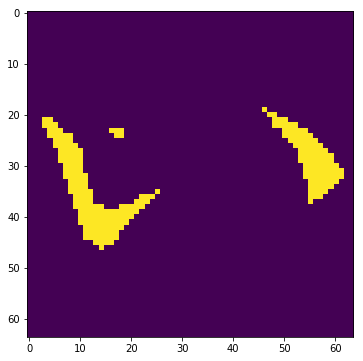

In [94]:

img_hat = Image.fromarray((img_hat_np).astype('uint8')).convert('L').convert('L')

plt.figure(figsize=(6,6))

plt.subplot(1,1,1)
plt.imshow(img_hat)

plt.show()

In [96]:
np.unique(np.array(img_hat)), y.shape, np.max(y)

(array([0, 1], dtype=uint8), (422387,), 54.0)

In [97]:
# Create train/validation split stratified by no conformity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


# y_stratification_ref = np.zeros((kuzushiji_df.shape[0]))
# for n in range(kuzushiji_df.shape[0]):
#     k = LABELS.index(kuzushiji_df.iloc[n,1])
#     y_stratification_ref[n] = k

n_split = 0 # for next
current_model='RESNET34'

stratus = kuzushiji_df.loc[kuzushiji_df['to_use']==1, 'encoded_page'].values*1000+y   #kuzushiji_df['label'].values
folds = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=random_state).split(X, stratus))


# df_tr = kuzushiji_df.iloc[folds[n_split][0]]
# df_ts = kuzushiji_df.iloc[folds[n_split][1]]

train_batches = DataGenerator(X,y,folds[n_split][0], shuffle = True, preprocess=None, 
         augmentation=None, batch_size=BATCH_SIZE)
valid_batches = DataGenerator(X,y,folds[n_split][1],preprocess=None, 
        batch_size=BATCH_SIZE)


In [98]:
stratus[:10]

array([26029., 26006., 26002., 26009., 26026., 26026., 26028., 26010.,
       26028., 26038.])

In [99]:
folds[0][0][:20]

array([368629, 357262,  46758,  95122, 369897, 218483,  31239, 299890,
       206297, 213318, 388803, 316636,  10659, 177942, 175867, 368573,
        98881, 360843, 259280, 224717])

In [100]:
np.unique(train_batches[4][0]), train_batches[4][0].shape

(array([0., 1.], dtype=float32), (32, 64, 64, 1))

In [103]:
y_true = train_batches[0][1]
y[1]

6.0

In [105]:
train_batches.indexes[:32]

array([368629, 357262,  46758,  95122, 369897, 218483,  31239, 299890,
       206297, 213318, 388803, 316636,  10659, 177942, 175867, 368573,
        98881, 360843, 259280, 224717, 112754, 208256,  85817,  33016,
       384766, 222731, 342714,  15122, 125929,  96208,   1216, 209890])

In [116]:
idx = 368629
l = kuzushiji_df.loc[(kuzushiji_df.index == idx) & (kuzushiji_df.to_use == 1), 'label'].values[0]
l = kuzushiji_df.loc[(kuzushiji_df.to_use == 1), 'label'].iloc[idx] #.values[0]
l, LABELS.index(l), y[idx]

('U+309D', 48, 48.0)

In [121]:
for num, idx in enumerate(train_batches.indexes[:32]):
    #l = kuzushiji_df.loc[(kuzushiji_df.index == idx) & (kuzushiji_df.to_use == 1), 'label'].values[0]
    l = kuzushiji_df.loc[(kuzushiji_df.to_use == 1), 'label'].iloc[idx] #.values[0]
    l, LABELS.index(l), y[idx]
    assert LABELS.index(l) == y[idx]
    tmp = np.zeros((len(LABELS)+1))
    tmp[LABELS.index(l)] = 1
    assert (tmp == y_true[num]).all()

    

In [123]:
l = 'U+309D'
tmp = np.zeros((len(LABELS)+1))
tmp[LABELS.index(l)] = 1

tmp, (tmp == y_true[0]).all()


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0.]), True)

In [124]:
"""ResNet v1, v2, and segmentation models for Keras.
# Reference
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
- [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)
Reference material for extended functionality:
- [ResNeXt](https://arxiv.org/abs/1611.05431) for Tiny ImageNet support.
- [Dilated Residual Networks](https://arxiv.org/pdf/1705.09914) for segmentation support
- [Deep Residual Learning for Instrument Segmentation in
   Robotic Surgery](https://arxiv.org/abs/1703.08580)
  for segmentation support.
Implementation Adapted from: github.com/raghakot/keras-resnet
"""  # pylint: disable=E501
from __future__ import division

import six
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape


def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(2, 2), initial_kernel_size=(7, 7), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,
                      strides=initial_strides)(img_input)
    if initial_pooling == 'max':
        x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model


def ResNet18(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2, 2, 2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


def ResNet101(input_shape, classes):
    """ResNet with 101 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 23, 3])


def ResNet152(input_shape, classes):
    """ResNet with 152 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 8, 36, 3])

In [161]:
model = ResNet(input_shape=(IMG_H,IMG_W,1), classes=len(LABELS)+1, 
       repetitions=[3, 4, 6, 3], initial_kernel_size=(3,3), activation='softmax')

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [162]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 32, 32, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 32, 32, 64)   256         conv2d_157[0][0]                 
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 32, 32, 64)   0           batch_normalization_160[0][0]    
__________________________________________________________________________________________________
max_poolin

In [189]:
def save_weights(model, file_name):
    states_h = []
    states_l = []
    for l in model.layers:
        states_h.append(l.trainable)
        l.trainable = True
#     for l in model.layers[1].layers:
#         states_l.append(l.trainable)
#         l.trainable = True

    model.save_weights(file_name, overwrite=True)

    for n, l in enumerate(model.layers):
        l.trainable = states_h[n]
#     for n, l in enumerate(model.layers[1].layers):
#         l.trainable = states_l[n]

    return
    
def load_weights(model, file_name):
    states_h = []
    states_l = []
    for l in model.layers:
        states_h.append(l.trainable)
        l.trainable = True
#     for l in model.layers[1].layers:
#         states_l.append(l.trainable)
#         l.trainable = True

    #model.load_weights(file_name, by_name=True)
    model.load_weights(file_name)


    for n, l in enumerate(model.layers):
        l.trainable = states_h[n]
#     for n, l in enumerate(model.layers[1].layers):
#         l.trainable = states_l[n]
    return model


In [190]:
# Define Top2 and Top3 Accuracy

def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

In [191]:
# Keras model
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras import callbacks
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score


# LOGGER
class Logger(callbacks.Callback):
    def __init__(self, out_path='./', patience=10, lr_patience=3, out_fn='', log_fn='', verbose=False, 
                 Xval=None, yval=None, val_gen=None):
        self.score = 0
        self.scores = []
        self.path = out_path
        self.fn = out_fn
        self.patience = patience
        self.lr_patience = lr_patience
        self.no_improve = 0
        self.no_improve_lr = 0
        self.Xval = Xval
        self.yval = yval
        self.val_gen = val_gen
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        if self.val_gen is not None:
            y_true = None
            for n in range(len(self.val_gen)):
                if y_true is None:
                    y_true = np.argmax(self.val_gen[n][1], axis=1)
                else:
                    y_true = np.vstack((y_true,np.argmax(self.val_gen[n][1],axis=1) ))
            self.yval= y_true.reshape((-1,1))
        
        self.on_epoch_end(-1, logs=logs)
        
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        cv_pred = self.model.predict_generator(self.val_gen)

        y_pred = np.zeros((len(cv_pred),1))
        for n in range(len(cv_pred)):
            y_pred[n] = np.argmax(cv_pred[n])
        cv_true = self.yval
        score = f1_score(cv_true, y_pred, average='macro')
        self.scores.append(score)
        if self.score < score:
            if epoch == -1: print('Initial F1 score: {}'.format(score))
            self.no_improve = 0
            self.no_improve_lr = 0
            if self.verbose:
                print("Epoch %s - best MCC: %s" % (epoch+1, round(score, 5)))
            self.score = score
            #self.model.save_weights(self.path + self.fn, overwrite=True)
            save_weights(self.model, self.path + self.fn)
        else:
            self.no_improve += 1
            self.no_improve_lr += 1
            if self.verbose:
                print("Epoch %s - current MCC: %s - best MCC: %s" % (epoch+1, round(score, 5), round(self.score, 5)))
            if self.no_improve >= self.patience:
                if not self.verbose:
                    print("Epoch %s - current MCC: %s - best MCC: %s" % (epoch+1, round(score, 5), round(self.score, 5)))
                self.model.stop_training = True
            if self.no_improve_lr >= self.lr_patience:
                lr = float(K.get_value(self.model.optimizer.lr))
                lr *= 10
                K.set_value(self.model.optimizer.lr, lr)
                if self.verbose:
                    print("Setting lr to {}".format(lr))
                self.no_improve_lr = 0
            else:
                lr = float(K.get_value(self.model.optimizer.lr))
                lr *= 0.975
                K.set_value(self.model.optimizer.lr, lr)
                if self.verbose:
                    print("Setting lr to {}".format(lr))
    
        if time.time() - kernel_start > kernel_time_limit:
            self.model.stop_training = True
            print('Time Limit reached.')
        return

    # matthews_corrcoef


In [192]:
!ls ../input/030a02c-model-weigths/030a02b__weights_0.h5

ls: cannot access '../input/030a02c-model-weigths/030a02b__weights_0.h5': No such file or directory


In [193]:
# make inference

In [194]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
# https://drive.google.com/file/d/1-HugyUoms-LIaAigvMTMTms-051vrS4i/view?usp=sharing                
file_id = '1-HugyUoms-LIaAigvMTMTms-051vrS4i'
destination = '../output/030a02c__weights_0.hdf5'
download_file_from_google_drive(file_id, destination)

# https://drive.google.com/file/d/1gTDswHKVS948J00hrFVKUwm2Q5oxZVzg/view?usp=sharing
file_id = '1gTDswHKVS948J00hrFVKUwm2Q5oxZVzg'
destination = '../output/030a02c_folds.pickle'
download_file_from_google_drive(file_id, destination)

In [195]:
# df_tr = kuzushiji_df.iloc[folds[n_split][0]]
# df_ts = kuzushiji_df.iloc[folds[n_split][1]]
import pickle

destination = '../output/030a02c_folds.pickle'
with (open(destination, "rb")) as openfile:
    folds = pickle.load(openfile)

train_batches = DataGenerator(X,y,folds[n_split][0], shuffle = True, preprocess=None, 
     augmentation=None, batch_size=BATCH_SIZE)
valid_batches = DataGenerator(X,y,folds[n_split][1],preprocess=None, 
    batch_size=BATCH_SIZE)

folds[0][1]

array([     5,      6,     16, ..., 422377, 422380, 422382])

In [200]:
model = load_weights(model, '../output/030a02c__weights_0.hdf5')
# Now it is equivalent to do:
# model.load_weights('../output/030a02c__weights_0.hdf5')


In [206]:
Xts, yts = train_batches[0]
y_pred = model.predict(Xts)

for a,b in zip (yts, y_pred):
    print(np.argmax(a),np.argmax(b), end=' . ')

38 38 . 37 37 . 29 29 . 49 49 . 21 21 . 0 0 . 29 29 . 43 43 . 43 43 . 39 39 . 21 21 . 29 29 . 47 47 . 28 28 . 37 37 . 42 42 . 38 38 . 21 21 . 38 38 . 17 17 . 29 29 . 5 5 . 46 46 . 23 23 . 37 37 . 4 4 . 19 19 . 42 42 . 2 2 . 5 5 . 13 13 . 7 7 . 

In [202]:
y_pred = model.predict_generator(valid_batches)
y_pred.shape

(85568, 56)

In [203]:
y_true = np.zeros((BATCH_SIZE*len(valid_batches), y_pred.shape[1]))

for n in range(len(valid_batches)):
    y_true[n*BATCH_SIZE:(n+1)*BATCH_SIZE] = valid_batches[n][1]

In [204]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

0.9439159498878086

In [205]:
f1_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='macro')

0.93568661880057

In [ ]:
# load_weights by name no funciona: los layers no tienen el nombre "apropiado"

In [ ]:
# trained model checked.

In [ ]:
# draft: how to apply class model to page.
# Excersise 1) given position of char, make submission.

In [210]:
#valid_batches, kuzushiji_df
kuzushiji_df.head()

,image_id,label,page,source,to_use,encoded_page
0,kkr_0.jpg,U+306F,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
1,kkr_1.jpg,U+304C,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
2,kkr_2.jpg,U+3044,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
3,kkr_3.jpg,U+3051,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
4,kkr_4.jpg,U+306B,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0


In [211]:
kuzushiji_df.loc[:, 'source'].values[0]

'../input/kuzushijibin/train_images/100241706_00004_2.jpg__0'

In [247]:
kuzushiji_df_val = kuzushiji_df.loc[kuzushiji_df.to_use==1, :].iloc[folds[n_split][1]]
kuzushiji_df_val.head(16)

,image_id,label,page,source,to_use,encoded_page
5,kkr_5.jpg,U+306B,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
6,kkr_6.jpg,U+306E,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
21,kkr_21.jpg,U+4EBA,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
38,kkr_38.jpg,U+305A,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
66,kkr_66.jpg,U+3057,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
67,kkr_67.jpg,U+306F,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
72,kkr_72.jpg,U+306B,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
77,kkr_77.jpg,U+3082,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
81,kkr_81.jpg,U+3093,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0
85,kkr_85.jpg,U+3089,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0


In [217]:
y_pred_encoded = model.predict_generator(valid_batches)

In [218]:
y_true_decoded = kuzushiji_df_val.loc[:, 'label'].values

y_true = np.zeros((y_true_decoded.shape[0]))
for n in range(y_true_decoded.shape[0]):
    y_true[n] = LABELS.index(y_true_decoded[n])

y_true[:20]


array([26., 28., 53., 14., 12., 29., 26., 37., 47., 40., 23., 31., 40.,
        5., 25., 20., 32., 12., 32., 12.])

In [221]:
y_pred = np.argmax(y_pred_encoded, axis=1)
y_pred

array([26, 28, 53, ..., 41, 30, 46])

In [220]:
y_pred_encoded = y_pred

In [226]:
accuracy_score(y_true[:len(y_pred)], y_pred), len(y_pred)-len(y_true)

(0.9439159498878086, -12)

In [227]:

# Prepare solutio & val_sunmission:
df_train=pd.read_csv(TRAIN_DIR + 'train.csv')
df_train.head()
#    solution, image_id, labels

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [238]:
solution = pd.DataFrame(columns=['image_id', 'labels'])

image_ids = [value.split('/')[-1].split('__')[0][:-4] for value in kuzushiji_df_val.source.values]

solution['image_id'] = np.unique(image_ids)

for image_id in solution.image_id.values:
    value = df_train.loc[df_train.image_id==image_id, 'labels'].values[0]
    solution.loc[solution.image_id==image_id, 'labels'] = value
    
solution.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [249]:
solution.shape
kuzushiji_df_val = kuzushiji_df_val[:len(y_pred)]
kuzushiji_df_val['pred'] = y_pred

kuzushiji_df_val['image_id_bis'] = [value.split('/')[-1].split('__')[0][:-4] for value in kuzushiji_df_val.source.values]

kuzushiji_df_val.head()

,image_id,label,page,source,to_use,encoded_page,pred,image_id_bis
5,kkr_5.jpg,U+306B,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0,26,100241706_00004_2
6,kkr_6.jpg,U+306E,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0,28,100241706_00004_2
21,kkr_21.jpg,U+4EBA,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0,53,100241706_00004_2
38,kkr_38.jpg,U+305A,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0,37,100241706_00004_2
66,kkr_66.jpg,U+3057,100241706,../input/kuzushijibin/train_images/100241706_0...,1,26.0,12,100241706_00004_2


In [261]:
sub = pd.DataFrame(columns=['image_id', 'labels'])
sub['image_id'] = np.unique(kuzushiji_df_val['image_id_bis'].values)

ct = 0
for image_id in sub.image_id.values:
    tmp = kuzushiji_df_val.loc[kuzushiji_df_val.image_id_bis==image_id,['pred', 'source']]
    labels = ''
    for n in range(tmp.shape[0]):
        labels += LABELS[int(tmp.iloc[n,0])] + ' '
        source = tmp.iloc[n,1]
        image_id = source.split('/')[-1].split('__')[0][:-4]
        pos = int(source.split('__')[1])
        ann = np.array(df_train.loc[df_train.image_id==image_id, 'labels'].values[0].split(' ')).reshape((-1,5))
        x = float(ann[pos,1])+float(ann[pos,3])//2; x = int(x)
        labels += str(x) + ' '
        y = float(ann[pos,2])+float(ann[pos,4])//2; y = int(y) 
        labels += str(y) + ' '

    labels = labels[:-1]
    sub.loc[solution.image_id==image_id, 'labels'] = labels
    
    ct += 1
#     if ct>10: break


sub.head()


,image_id,labels
0,100241706_00004_2,U+306B 962 3491 U+306E 951 2925 U+4EBA 308 211...
1,100241706_00005_1,U+306F 1138 2050 U+306B 2086 1400 U+3082 2063 ...
2,100241706_00005_2,U+306F 634 1404 U+306E 1585 2114 U+3078 972 17...
3,100241706_00006_1,U+304B 748 2936 U+306E 1396 1591 U+304D 2048 3...
4,100241706_00007_2,U+309D 1214 2965 U+3064 1497 2794 U+306E 970 2...


In [265]:
import argparse
import multiprocessing
import sys

import numpy as np
import pandas as pd


def define_console_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--sub_path', type=str, required=True)
    parser.add_argument('--solution_path', type=str, required=True)
    return parser


def score_page(preds, truth):
    """
    Scores a single page.
    Args:
        preds: prediction string of labels and center points.
        truth: ground truth string of labels and bounding boxes.
    Returns:
        True/false positive and false negative counts for the page
    """
    tp = 0
    fp = 0
    fn = 0

    truth_indices = {
        'label': 0,
        'X': 1,
        'Y': 2,
        'Width': 3,
        'Height': 4
    }
    preds_indices = {
        'label': 0,
        'X': 1,
        'Y': 2
    }

    if pd.isna(truth) and pd.isna(preds):
        return {'tp': tp, 'fp': fp, 'fn': fn}

    if pd.isna(truth):
        fp += len(preds.split(' ')) // len(preds_indices)
        return {'tp': tp, 'fp': fp, 'fn': fn}

    if pd.isna(preds):
        fn += len(truth.split(' ')) // len(truth_indices)
        return {'tp': tp, 'fp': fp, 'fn': fn}

    truth = truth.split(' ')
    if len(truth) % len(truth_indices) != 0:
        raise ValueError('Malformed solution string')
    truth_label = np.array(truth[truth_indices['label']::len(truth_indices)])
    truth_xmin = np.array(truth[truth_indices['X']::len(truth_indices)]).astype(float)
    truth_ymin = np.array(truth[truth_indices['Y']::len(truth_indices)]).astype(float)
    truth_xmax = truth_xmin + np.array(truth[truth_indices['Width']::len(truth_indices)]).astype(float)
    truth_ymax = truth_ymin + np.array(truth[truth_indices['Height']::len(truth_indices)]).astype(float)

    preds = preds.split(' ')
    if len(preds) % len(preds_indices) != 0:
        raise ValueError('Malformed prediction string')
    preds_label = np.array(preds[preds_indices['label']::len(preds_indices)])
    preds_x = np.array(preds[preds_indices['X']::len(preds_indices)]).astype(float)
    preds_y = np.array(preds[preds_indices['Y']::len(preds_indices)]).astype(float)
    preds_unused = np.ones(len(preds_label)).astype(bool)

    for xmin, xmax, ymin, ymax, label in zip(truth_xmin, truth_xmax, truth_ymin, truth_ymax, truth_label):
        # Matching = point inside box & character same & prediction not already used
        matching = (xmin < preds_x) & (xmax > preds_x) & (ymin < preds_y) & (ymax > preds_y) & (preds_label == label) & preds_unused
        if matching.sum() == 0:
            fn += 1
        else:
            tp += 1
            preds_unused[np.argmax(matching)] = False
    fp += preds_unused.sum()
    return {'tp': tp, 'fp': fp, 'fn': fn}


def kuzushiji_f1(sub, solution):
    """
    Calculates the competition metric.
    Args:
        sub: submissions, as a Pandas dataframe
        solution: solution, as a Pandas dataframe
    Returns:
        f1 score
    """
    if not all(sub['image_id'].values == solution['image_id'].values):
        raise ValueError("Submission image id codes don't match solution")

    pool = multiprocessing.Pool()
    results = pool.starmap(score_page, zip(sub['labels'].values, solution['labels'].values))
    pool.close()
    pool.join()

    tp = sum([x['tp'] for x in results])
    fp = sum([x['fp'] for x in results])
    fn = sum([x['fn'] for x in results])

    if (tp + fp) == 0 or (tp + fn) == 0:
        return 0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision > 0 and recall > 0:
        f1 = (2 * precision * recall) / (precision + recall), tp, fp, fn
    else:
        f1 = 0
    return f1, tp, fp, fn


In [267]:
score, tp, fp, fn = kuzushiji_f1(sub, solution)
print('F1 score of: {0}, (tp:{1}, fp:{2}, fn:{3})'.format(score, tp, fp, fn))

F1 score of: (0.21111400077628895, 80770, 4798, 598841), (tp:80770, fp:4798, fn:598841)


In [ ]:
# working on big_boxes
#image_id, encoded_pred, x, y

In [331]:
from PIL import Image, ImageEnhance 

IMG_ROWS=300
IMG_COLS=300

# Chequea dimensional
def VisualizeKuzushiji_hat(imagePath, imgenhance=False, use_columns_filter=True, draw_big_box=True):
    if imgenhance:
        imsource = Image.open(imagePath)#fromarray(img)

        enhancer = ImageEnhance.Contrast(imsource)
        enhanced_im = enhancer.enhance(0.8)
        enhanced_im.save('./borrar'+imagePath[-4:])

        img = cv2.imread('./borrar'+imagePath[-4:])
    else:
        img = cv2.imread(imagePath) # img is numpy.array
        imsource = Image.open(imagePath)#fromarray(img)
#         img[:,:,0] = (np.absolute(1-np.array(preprocess_hat(imsource)))*255.0) # No funciona
#         img[:,:,1] = (np.absolute(1-np.array(preprocess_hat(imsource)))*255.0) # No funciona
#         img[:,:,2] = (np.absolute(1-np.array(preprocess_hat(imsource)))*255.0) # No funciona
        
    char_draw = ImageDraw.Draw(imsource)
    im_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, im_th = cv2.threshold(im_grey, 130, 255, cv2.THRESH_BINARY_INV)
    ctrs,_ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    if use_columns_filter:
        rects_hat = []
        for rect in rects:
            # filtro. doc  x, y, w, h = cv2.boundingRect(approx)
            w,h = rect[2],rect[3]
            if not check_dim(w,h): continue

            leng_h = int(rect[3] * 1.6)
            leng_w = int(rect[2] * 1.6)
            pt1 = int(rect[1] + rect[3]//2 - leng_h// 2)
            pt2 = int(rect[0] + rect[2]//2 - leng_w// 2)
            roi = im_th[pt1:pt1+leng_h, pt2:pt2+leng_w]
            if roi.size>7000:
                rects_hat.append(rect)
        columns = get_columns(rects_hat)
        columns = columns_filter(columns)
        rects_hat = []
        big_boxes = []
        for column in columns:
            x_min, x_max, y_min,y_max = 10000,0,10000,0
            for rect in column:
                rects_hat.append(rect)
                x,y,w,h=rect
                x_min,x_max = min(x_min,x),max(x_max,x+w)
                y_min,y_max = min(y_min,y),max(y_max,y+h)
            if draw_big_box:
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (225, 250, 0), 6)
                print((x_min, y_min), (x_max, y_max))
            if y_min < 500:
                print(column)
            big_boxes.append({x_min,y_min,x_max-x_min,y_max-y_min})
        rects = copy.copy(rects_hat)

    Kuzushijis = []
    rects_hat = []
    for num, rect in enumerate(rects):
        # filtro. doc  x, y, w, h = cv2.boundingRect(approx)
        w,h = rect[2],rect[3]
        if not check_dim(w,h): continue
        
        leng_h = int(rect[3] * 1.6)
        leng_w = int(rect[2] * 1.6)
        pt1 = int(rect[1] + rect[3]//2 - leng_h// 2)
        pt2 = int(rect[0] + rect[2]//2 - leng_w// 2)
        roi = im_th[pt1:pt1+leng_h, pt2:pt2+leng_w]
        #bbox_draw.rectangle((rect[0], rect[1], rect[0] + rect[2],rect[1] + rect[3]), fill=(0, 225, 0, 0))
        #print(roi.size)
        if roi.size>7000:
            rects_hat.append(rect)
            cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (225, 0, 0), 6)
            roi = cv2.resize(roi, (300,300))
            #roi = cv2.dilate(roi, (3, 3))
            ret,th1 = cv2.threshold(roi,155,255,cv2.THRESH_BINARY)
            ProcessImage = th1.reshape(1,IMG_ROWS, IMG_COLS, 1)
            y_pred = [[0,0,0,1]] #y_pred = Model_.predict(ProcessImage)
            y_true = np.argmax(y_pred,axis=1)
            Kuzushiji = [0,1] # Kuzushiji = lb.inverse_transform(y_true)
            #print(Kuzushiji[0])
            Kuzushijis.append(str(Kuzushiji[0]))
            char_draw.text((rect[0]+10, rect[1]),str(Kuzushiji[0]), fill=(0,22,225,0), font=font)
            #cv2.putText(img, str(Kuzushiji[0]), (rect[0], rect[1]),font, 2, (0, 255, 255), 3)
    return img,imsource, rects_hat

In [332]:
def PlotVisualizeKuzushiji(image_file):
    img1, imsource1, rects_hat = VisualizeKuzushiji_hat(image_file)
    plt.figure(figsize=(30,30))
    plt.subplot(1,2,1)
    plt.title("Detection of Kuzushiji",fontsize=20)
    plt.imshow(img1)
    plt.subplot(1,2,2)
    plt.title("Ground True of Kuzushiji",fontsize=20)
    #plt.imshow(imsource1)
    fn = image_file.split('/')[-1][:-4]
    label = df_train.loc[df_train['image_id']==fn,'labels'].values[0]
    img = visualize_training_data_hat(image_file, label)    
    plt.imshow(img)
    plt.show()
    
    return rects_hat


In [333]:
## Recover char image for train_images.
# crop & save
from tqdm import tqdm
count=0

pic_count=0
heighs, widths = [],[]
for i in tqdm(range(len(df_train))):
    tmp = df_train.loc[i,["image_id", 'labels']].values
    image_id, labels = tmp[0], tmp[1]
    if labels == np.nan: continue
    if type(labels) == float: continue
    ann_pic = "{}{}.jpg".format(TRAIN_DIR + 'train_images/', image_id)
    ann=np.array(labels.split(" ")).reshape(-1,5)#cat,x,y,width,height for each picture
    with Image.open(ann_pic) as img:
        pic_count+=1
        for num, j in enumerate(ann[:,0]):
            widths.append(float(ann[num,3]))
            heighs.append(float(ann[num,4]))

100%|██████████| 3605/3605 [00:04<00:00, 885.89it/s]


In [334]:
#len(widths), len(heighs)
heighs = np.array(heighs)
widths = np.array(widths)

areas = heighs *  widths
widths_to_heighs = widths / heighs
heighs_to_widths = heighs / widths

area_max = np.max(areas)
area_min = np.min(areas)
h_to_w_max = np.max(heighs_to_widths)
h_to_w_min = np.min(heighs_to_widths)
w_to_h_max = np.max(widths_to_heighs)
w_to_h_min = np.min(widths_to_heighs)
h_max = np.max(heighs)
w_max = np.max(widths)
h_min = np.min(heighs)
w_min = np.min(widths)

def check_dim(w,h):
    if w <= 0 or h <= 0: 
        return False
    if w * h > 2 * area_max:
        return False
    if w * h < 0.95 * area_min:
        return False
    if 1.0 * h / w > 1.25 * h_to_w_max:
        return False
    if 1.0 * h / w < 0.9 * h_to_w_min:
        return False
    if 1.0 * w / h > 1.1 * w_to_h_max:
        return False
    if 1.0 * w / h < 0.9 * w_to_h_min:
        return False
    if h > 2 * h_max or w > 1.1 * w_max:
        return False
    if h < 0.9 * h_min or w < 0.9 * w_min:
        return False
    return True
    
    

In [335]:
import copy

def vertical_intersection(rects, ref):
    column = []
    rects_bis = copy.copy(rects)
    if len(rects) == 0:
        return column, rects
    
    if len(ref) != 4:
        print(ref)
    
    x_min, _, w, _ = ref #[0],ref[1],ref[2],ref[3]
    x_max = x_min + w
    ct = 0
    for num, rect in enumerate(rects):
        x,_,w,_ = rect
        x_center = 1.0* (x+w/2)
        if (x_center >= x_min) and (x_center <= x_max):
            column.append(rect)
            rects_bis.pop(ct)
        else:
            ct += 1
    return column, rects_bis

# tengo elementos con y_center comun?

# devuelve tuple 2 rects con y_center en comun.
def vertical_clean(rects):
    if len(rects) == 0:
        return None

    for rect in rects:
        _, y_min, _, h = rect #[0],ref[1],ref[2],ref[3]
        y_max = y_min + h
        rects_bis = copy.copy(rects)
        rects_bis.remove(rect)

        for num, rect_bis in enumerate(rects_bis):
            _,y,_,h = rect_bis
            y_center = 1.0* (y+h/2)
            if (y_center >= y_min) and (y_center <= y_max):
                return (rect, rect_bis)
    return None

def vertical_count(rects, ref):
    if len(rects) == 0:
        return 0
    
    if len(ref) != 4:
        print('Error: not a rect.' +ref)
    
    x_min, _, w, _ = ref #[0],ref[1],ref[2],ref[3]
    x_max = x_min + w
    ct = 0
    for num, rect in enumerate(rects):
        x,_,w,_ = rect
        x_center = 1.0* (x+w/2)
        if (x_center >= x_min) and (x_center <= x_max):
            ct += 1
    return ct

def vertical_cleaner(rects, column):
    while vertical_clean(column) is not None:
        r = vertical_clean(column)
        q0, q1 = vertical_count(column, r[0]), vertical_count(column, r[1])

        if q0 > q1:
            column.remove(r[1])
            rects.append(r[1])
        elif q1 > q0:
            column.remove(r[0])
            rects.append(r[0])
        elif r[0][2]*r[0][3] > r[1][2]*r[1][3]:
            column.remove(r[1])
            rects.append(r[1])
        else:
            column.remove(r[0])
            rects.append(r[0])
    return rects, column
        
def rects_exclude(rects, column):
    for rect in column:
        if rect in rects:
            rects.remove(rect)
    return rects



In [336]:
def get_columns(rects):
    
    columns = []
    while len(rects) > 1:
        #print('len(columns)={}'.format(len(columns)))
        column = []

        r0 = rects[0]
        column.append(r0)
        rects.pop(0)

        # completa la columna
        for _ in range(16):
            column_qty = len(column)
            for n in range(column_qty):
                inters, rects = vertical_intersection(rects, column[n])
                column += inters
        # limpia column de character laterales
        rects, column = vertical_cleaner(rects, column)
        columns.append(column)

        # limpia rects
        rects = rects_exclude(rects, column)
        if len(rects) == 1:
            columns.append(rects)
            rects = []
    return columns
    
# return a list of rect list with focus in len & position.
# columns is list of rect list
def columns_filter(columns):
    if columns is None: return []
    if len(columns) == 0: return []
    # Si tengo + de 6 columnas.
    columns_len = [len(column) for column in columns]

    big_columns = []
    for n in list(np.argsort(columns_len)[-6:]):
        big_columns.append(columns[n])
        
    x_centers = []
    for column in big_columns:
        x_center = 0
        ct = 0
        for rect in column:
            x,_,w,_ = rect
            x_center += 1.0*x + w/2
            ct += 1
        x_centers.append(x_center/ct)
    x_centers = np.sort(x_centers)

    x_centers_diff = np.diff(x_centers)
    x_centers_diff = np.sort(x_centers_diff)
    
    d = []
    mult = 1
    for x_center_diff in x_centers_diff:
        if len(d) == 0:
            d.append(x_center_diff)
        else:
            m = np.sum(d)/len(d)
            r = find_multiple(x_center_diff, m, gap=0.12)
            if r is None:
                break
            d.append(r[0])
    column_setp = np.sum(d)/len(d)

    x_centers_pred = [x_centers[0]+n*column_setp for n in range(10) ]

    
    columns_range = []
    for column in columns:
        x_min = 10000
        x_max = 0

        ct = 0
        centers = []
        for rect in column:
            x,_,w,_ = rect
            x_min = min(x_min, x)
            x_max = max(x_max, x+w)
            ct += 1
            centers.append(1.0*x + w/2)
        columns_range.append((np.mean(centers)-3*np.std(centers),np.mean(centers)+3*np.std(centers)))


    columns_pred = []

    for x_center_pred in x_centers_pred:
        tmp = None
        for num, column_range in enumerate(columns_range):
            x_min, x_max = column_range
            if x_min < x_center_pred and x_center_pred < x_max:
                if tmp is None:
                    tmp = columns[num]
                elif area_column(columns[num]) > area_column(tmp):
                    tmp = columns[num]
        if tmp is not None:
            columns_pred.append(tmp)
    return columns_pred
        
def area_column(column):
    area = 0
    for rect in column:
        _,_,w,h = rect
        area += w*h
    return area
    
def find_multiple(num, ref, gap=0.1):
    m = 1.0
    num_hat = num / m
    while not (num_hat < (1+gap)*ref):
        m += 1
        num_hat = num / m
    if num_hat <= (1-gap)*ref:
        return None
    return num_hat, m

#find_multiple(464.34444444, 250.375, gap=0.1)    

In [337]:
def element_qty_mean(columns):
    ct = 0
    for column in columns:
#        print(str(len(column)))
        ct += len(column)

    return 1.0*ct/len(columns)

def remove_by_len(columns):
    len_mean = element_qty_mean(columns)
    columns_bis = copy.copy(columns)
    for column in columns:
        if len(column) < len_mean:
            columns_bis.remove(column)
    return columns_bis


# This function takes in a filename of an image, and the labels in the string format given in train.csv, and returns an image containing the bounding boxes
def visualize_training_data_hat(image_fn, labels):
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    for codepoint, x, y, w, h in labels:
        x, y, w, h = int(x), int(y), int(w), int(h)
        char = unicode_map[codepoint] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        bbox_draw.line([(x,y),(x+w,y+h),(x+w,y),(x,y+h)], fill=(255, 0, 0), width=4)
        char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(0, 0, 255, 255), font=font)

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return imsource

(101, 672) (313, 2928)
(262, 643) (451, 2944)
(481, 523) (615, 2929)
(637, 532) (802, 2934)
(822, 557) (969, 2924)
(943, 584) (1148, 2941)
(1175, 536) (1303, 2745)
(1294, 547) (1539, 2927)
(1463, 549) (1679, 2921)
(1664, 540) (1808, 2930)


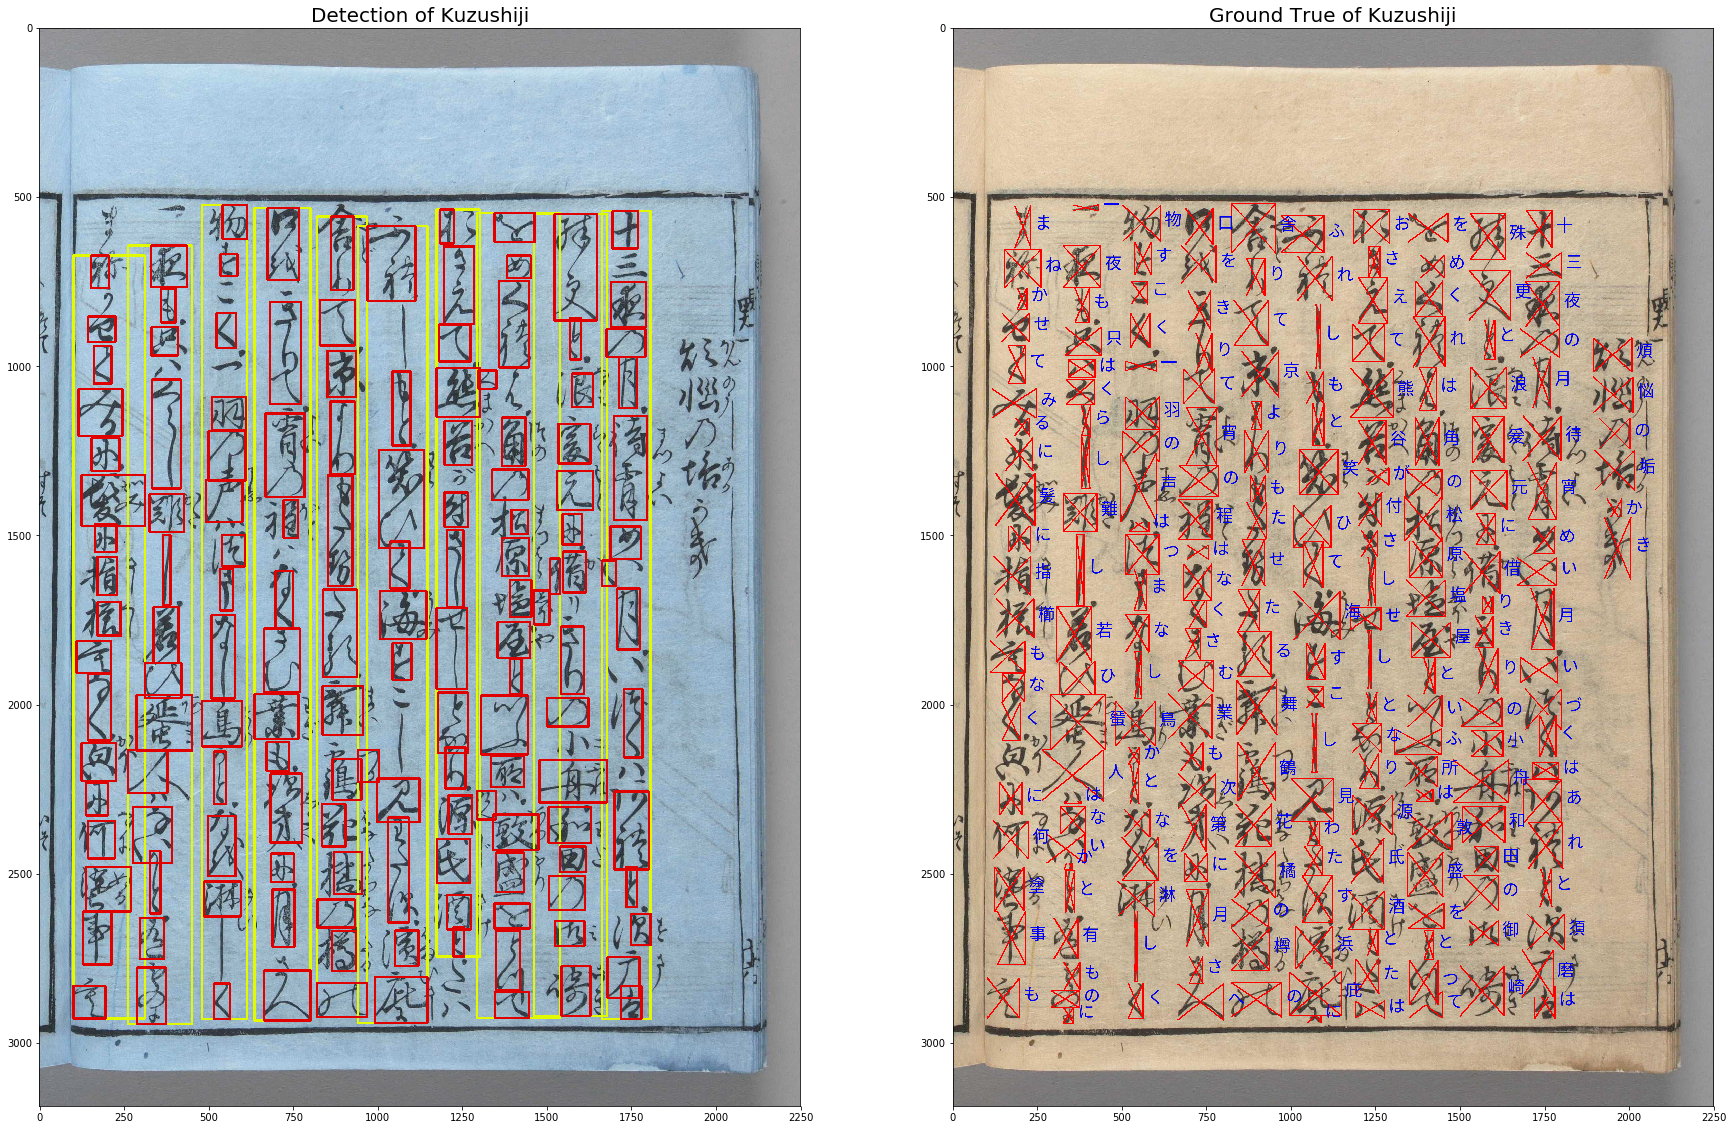

'200003076_00020_1'

In [346]:
#for i in range(50,52):
for i in range(522,523):
    ann_pic = "{}{}.jpg".format(TRAIN_DIR + 'train_images/',df_train.loc[i,"image_id"])
    rects_hat = PlotVisualizeKuzushiji(ann_pic)
df_train.loc[i,"image_id"]

In [339]:
len(rects_hat)

145

In [402]:
def get_bix_boxes(rects_hat):
    columns = get_columns(rects_hat)
    columns = columns_filter(columns)
    rects_hat = []
    big_boxes = []
    for column in columns:
        x_min, x_max, y_min,y_max = 10000,0,10000,0
        for rect in column:
            rects_hat.append(rect)
            x,y,w,h=rect
            x_min,x_max = min(x_min,x),max(x_max,x+w)
            y_min,y_max = min(y_min,y),max(y_max,y+h)
        if y_min < 500:
            print(column)
        big_boxes.append( (x_min,y_min,x_max-x_min,y_max-y_min) )
    rects = copy.copy(rects_hat)
    
    return big_boxes


In [414]:
len(get_bix_boxes(rects_hat)), len(rects_hat)

(9, 139)

In [415]:
bix_boxes = get_bix_boxes(rects_hat)
bb=bix_boxes[0]; image_id='200003076_00020_1'

In [447]:
ann_pic = "{}{}.jpg".format('../input/kuzushijibin/train_images/',image_id)
ann_pic

with Image.open(ann_pic) as img:
    img = img.crop( (bb[0],bb[1],bb[0]+bb[2],bb[1]+bb[3]) )



w,h=img.size

In [420]:
stride = 0.05
step = int(w*stride)
n = (h-w) // int(w*stride)

Xval = np.zeros((n,IMG_H,IMG_W,1))

for n in range(Xval.shape[0]):
    img_bis = img.crop((0,n*step,w,n*step+w)).resize(size=(IMG_W,IMG_H), resample=Image.ANTIALIAS)
    Xval[n] = np.clip((-1*np.array(img_bis)/255+1)/0.8,0,1).reshape((IMG_H,IMG_W,1))
    
    

In [421]:
Xval.shape, n, step, w, h

((234, 64, 64, 1), 233, 9, 189, 2301)

In [422]:
# [np.sum(Xval[n]) for n in range(Xval.shape[0])], np.unique(Xval)
encoded_y_pred = model.predict(Xval) 
y_pred = np.argmax(encoded_y_pred, axis=1)
for n in range(len(y_pred)):
    print(y_pred[n], end=', ')

38, 16, 38, 34, 34, 34, 21, 12, 12, 12, 40, 7, 12, 25, 25, 3, 25, 34, 34, 46, 28, 28, 20, 0, 5, 28, 28, 3, 40, 40, 6, 25, 40, 2, 40, 40, 28, 7, 19, 7, 16, 7, 7, 26, 21, 21, 21, 26, 12, 12, 17, 17, 37, 37, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 28, 28, 32, 32, 26, 26, 4, 34, 34, 34, 34, 38, 46, 43, 43, 43, 34, 9, 7, 41, 26, 0, 0, 26, 12, 12, 28, 12, 12, 12, 12, 20, 29, 46, 26, 12, 20, 26, 26, 46, 46, 46, 46, 46, 46, 34, 46, 34, 34, 34, 44, 1, 1, 43, 34, 43, 28, 28, 49, 43, 28, 20, 41, 13, 31, 31, 31, 31, 12, 20, 20, 7, 32, 7, 26, 15, 17, 15, 38, 38, 38, 14, 14, 14, 52, 14, 38, 14, 3, 3, 3, 21, 21, 30, 53, 53, 53, 53, 53, 33, 33, 33, 33, 33, 29, 29, 46, 24, 46, 46, 38, 3, 46, 37, 37, 23, 18, 18, 28, 14, 0, 13, 14, 6, 14, 3, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 40, 40, 40, 7, 24, 18, 24, 24, 40, 34, 43, 34, 25, 43, 43, 14, 7, 34, 37, 34, 35, 7, 35, 7, 13, 34, 7, 34, 34, 

In [423]:
def is_inside(box, big_box):
    x_center, y_center = 1.0*box[0]+box[2]/2, 1.0*box[1]+0.5*box[3]
    if (x_center>big_box[0]) and (x_center<big_box[0]+big_box[2]) and (y_center>big_box[1]) and (y_center<big_box[1]+big_box[3]):
        return True
    return False

annotations = np.array(df_train.loc[df_train.image_id==image_id, 'labels'].values[0].split(' ')).reshape((-1,5))

for ann in annotations:
    x,y,w,h = int(ann[1]),int(ann[2]),int(ann[3]),int(ann[4])
    if is_inside(box=(x,y,w,h), big_box=bb):
        try:
            print(ann[0], LABELS.index(ann[0]))
        except:
            pass

U+306F 29
U+306B 26
U+306E 28
U+306F 29
U+304B 5
U+304F 8
U+3082 37
U+306A 25
U+3044 2
U+3089 40
U+3082 37
U+3072 31
U+3068 23
U+4EBA 53
U+3057 12
U+3057 12


In [439]:
def predict_rect(rect, img, model):
    x,y,w,h = int(rect[0]),int(rect[1]),int(rect[2]),int(rect[3])
    
    img_bis = img.crop((x,y,x+w,y+h))
    old_size = img_bis.size  # old_size[0] is in (width, height) format
    new_size = tuple([max(old_size) for _ in old_size])

    new_im = Image.new("L", size=new_size, color=(255))

    new_im.paste(img_bis, ((max(old_size)-old_size[0])//2,
                (max(old_size)-old_size[1])//2))
    img_bis = new_im


    img_bis = img_bis.resize(size=(IMG_W,IMG_H), resample=Image.ANTIALIAS)
    Xval = np.clip((-1*np.array(img_bis)/255+1)/0.8,0,1).reshape((1,IMG_H,IMG_W,1)).astype(np.dtype('b'))
    ennconded_y_pred = model.predict(Xval)

    return np.argmax(ennconded_y_pred, axis=1) 

In [457]:
rects_hat

rects_hat_filtered = [rect for rect in rects_hat if is_inside(box=rect, big_box=bb)]
ann_pic = "{}{}.jpg".format('../input/kuzushijibin/train_images/',image_id)
img = Image.open(ann_pic)

for rect in rects_hat_filtered:
    x,y,w,h = int(rect[0]),int(rect[1]),int(rect[2]),int(rect[3])
    x,y,w,h = x+5,y+5,w+10,h+10
    if is_inside(box=(x,y,w,h), big_box=bb):
        for ann in annotations:
            x_hat,y_hat,w_hat,h_hat = int(ann[1]),int(ann[2]),int(ann[3]),int(ann[4])
            if is_inside(box=(x_hat,y_hat,w_hat,h_hat), big_box=(x,y,w,h)):
                print('box=({},{}),({},{})'.format(x_hat,y_hat,x_hat+w_hat,y_hat+h_hat))
                print('rect=({},{}),({},{})'.format(x,y,x+w,y+h))
                if ann[0] in LABELS:
                    print('{} -> {}; P? {}.'.format(ann[0], LABELS.index(ann[0]), predict_rect((x_hat,y_hat,w_hat,h_hat), img, model)))
                else:
                    print('{} x'.format(ann[0]))
                    
        #
        img_bis = img.crop((x,y,x+w,y+h))
        old_size = img_bis.size  # old_size[0] is in (width, height) format
        new_size = tuple([max(old_size) for _ in old_size])

        new_im = Image.new("L", size=new_size, color=(255))

        new_im.paste(img_bis, ((max(old_size)-old_size[0])//2,
                    (max(old_size)-old_size[1])//2))
        img_bis = new_im


        img_bis = img_bis.resize(size=(IMG_W,IMG_H), resample=Image.ANTIALIAS)
        Xval = np.clip((-1*np.array(img_bis)/255+1)/0.8,0,1).reshape((1,IMG_H,IMG_W,1))
        ennconded_y_pred = model.predict(Xval)
        print(' 0) {}'.format(np.argmax(ennconded_y_pred, axis=1)))
        

    

box=(324,2893),(357,2943)
rect=(294,2782),(390,2959)
U+306B -> 26; P? [26].
box=(289,2845),(374,2895)
rect=(294,2782),(390,2959)
U+306E -> 28; P? [28].
box=(327,2761),(375,2844)
rect=(294,2782),(390,2959)
U+3082 -> 37; P? [37].
 0) [34]
box=(298,2631),(370,2751)
rect=(303,2636),(385,2767)
U+6709 x
 0) [7]
box=(327,2431),(352,2487)
rect=(333,2437),(374,2632)
U+304B -> 5; P? [5].
box=(332,2490),(359,2616)
rect=(333,2437),(374,2632)
U+3068 -> 23; P? [23].
 0) [12]
box=(327,2431),(352,2487)
rect=(283,2307),(407,2483)
U+304B -> 5; P? [5].
box=(317,2301),(391,2384)
rect=(283,2307),(407,2483)
U+306A -> 25; P? [25].
box=(277,2383),(390,2469)
rect=(283,2307),(407,2483)
U+3044 -> 2; P? [2].
 0) [7]
box=(329,2256),(378,2292)
rect=(267,2139),(394,2276)
U+306F -> 29; P? [29].
box=(262,2133),(445,2284)
rect=(267,2139),(394,2276)
U+4EBA -> 53; P? [53].
 0) [53]
box=(288,1970),(450,2134)
rect=(293,1976),(466,2151)
U+8711 x
 0) [38]
box=(314,1870),(420,1979)
rect=(318,1882),(436,1995)
U+3072 -> 31; P? 

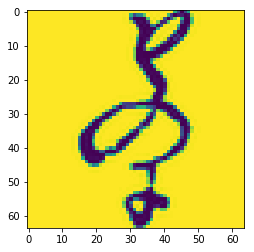

In [454]:
plt.imshow(img_bis)

In [ ]:
# (101, 672) (313, 2928)
# (262, 643) (451, 2944)
# (481, 523) (615, 2929)
# (637, 532) (802, 2934)
# (822, 557) (969, 2924)
# (943, 584) (1148, 2941)
# (1175, 536) (1303, 2745)
# (1294, 547) (1539, 2927)
# (1463, 549) (1679, 2921)
# (1664, 540) (1808, 2930)

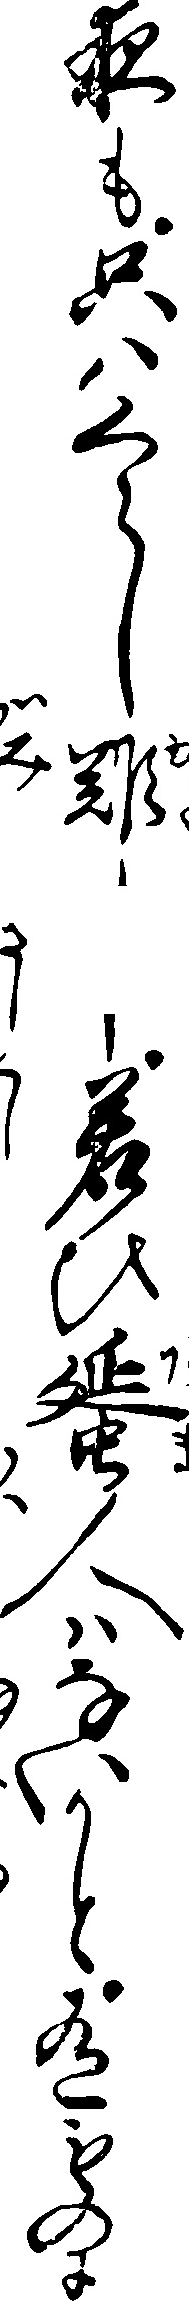

In [450]:
img

In [ ]:
# EOF ------------------------------------------------------------------------------------------------------

In [0]:
import pickle
from keras import optimizers


for n_split in range(N_SPLITS):
    K.clear_session()
    _ = tf.Session(config=config)

    sess = tf.Session(config=config)
    K.tensorflow_backend.set_session(sess)
    K.set_session(sess)

    keras.backend.set_image_data_format('channels_last')

    print("-=-=-=-=-    Fold {} / {}.    -=-=-=-=-=-=-=-=-=-=-=-=-".format(n_split+1,N_SPLITS))
#     df_tr = kuzushiji_df.iloc[folds[n_split][0]]
#     df_ts = kuzushiji_df.iloc[folds[n_split][1]]

#         train_batches = DataGenerator(df_tr,shuffle = True, preprocess=[keras_models[current_model][0],adjustData], 
#                 #augmentation=get_training_augmentation, 
#                                       batch_size=BATCH_SIZE)
#         valid_batches = DataGenerator(df_ts,preprocess=[keras_models[current_model][0],adjustData], 
#                 batch_size=BATCH_SIZE)
    train_batches = DataGenerator(X,y,folds[n_split][0],shuffle = True, preprocess=None, 
            #augmentation=get_training_augmentation, 
                                  batch_size=BATCH_SIZE)
    valid_batches = DataGenerator(X,y,folds[n_split][1],preprocess=None, 
            batch_size=BATCH_SIZE)

    logger = Logger(patience=60, lr_patience=16, out_path=OUTPUT_DIR, val_gen=valid_batches,
                   out_fn='{}__weights_{}.h5'.format(PREF, n_split), verbose=True)

    filepath = "{}{}__weights_{}.hdf5".format(OUTPUT_DIR, PREF, n_split) #"saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
    model_checkpoint = ModelCheckpoint(filepath, monitor = 'val_categorical_accuracy', verbose = 1,
                                      save_best_only = True, save_weights_only = True, period = 1)
    model = ResNet(input_shape=(IMG_H,IMG_W,1), classes=len(LABELS)+1, # 1+ for backgroud. 
       repetitions=[3, 4, 6, 3], initial_kernel_size=(3,3), activation='softmax')
    
    #load_weights(model, '../input/030a02c-model-weigths/030a02b__weights_0.h5')
    
    model.compile(optimizers.Adam(lr=0.000025), loss='categorical_crossentropy', 
          metrics=[keras.metrics.categorical_accuracy, top_2_accuracy, top_3_accuracy])

    history = model.fit_generator(train_batches,  
                                  #class_weight=class_weights,
                        validation_data=valid_batches,
                        epochs=32, verbose=1,
                       callbacks=[logger, model_checkpoint])

    with open('{}_{}_scores_{}.pickle'.format(PREF, current_model, n_split), 'wb') as handle:
        pickle.dump(logger.scores, handle)
    with open('{}_{}_history_{}.pickle'.format(PREF, current_model, n_split), 'wb') as handle:
        pickle.dump(history, handle)
    if time.time() - kernel_start > kernel_time_limit:
        print('Time Limit reached.')
        break


        
        

In [0]:
tic_tac(False)

In [0]:
# EOF